# Predicting Voter Turnout in Massachusetts Using Food Access Index

## Problem Definition and Data Source

**Project Goal**: Our goal is to predict the voter turnout in Massachusetts using the National Voter Database for addresses in Massachusetts and the Massachusetts Food Access Index Database. 

**Dataset**: 
Sources: 
-National Voter Database
-Massachusetts Food Access Index Database (https://datacommon.mapc.org/browser/datasets/417)

**Project Overview** 
1. Install Necessary Packages and Data
    1. Install Packages 
    2. Import CSV File 
2. Data Preparation
    1. Replace Null Values
    2. Dropping Columns
3. Prepare Food Index Dataset 
    1. Import CSV File
    2. Create Census Block ID, concatenation and join
    3. Concatenating State ID, County ID, Tract, and Block Group
    4. Join Food Index Dataset and Voter ataset
4. Exploratory Data Analysis
5. Machine Learning
    1. Logistic Regression
    2. Feature Importance with Logistic Regression
    3. Random Forest Classification Model 
6. Conclusion 
7. Challenges
8. Appendix


**Description of Columns:**

Please see appendix at the end for detailed table of column names and data type (Exhibit A).


## 1. Install Necessary Packages and Import Data

### 1A. Install Packages

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, DoubleType
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import seaborn as sns
import numpy as np
import pandas as pd
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

### 1B. Import CSV File

In [ ]:
data = "gs://voter-files/"

In [ ]:
# Read parquet file
voter_data_MA = spark.read.format("parquet")\
    .option("header", "true")\
    .load(data + "voter_data_MA.parquet")

In [ ]:
# Counting all the rows in the dataframe
voter_data_MA.count()

4572639

## 2. Data Preparation

In [ ]:
voter_data_MA_original = voter_data_MA

### 2A. Replace null values 

In [ ]:
# A lot of NULL values exist because some dummmy columns have null instead of N
voter_data_MA.select('General_2000').distinct().show()

+------------+
|General_2000|
+------------+
|        null|
|           Y|
+------------+



In [ ]:
# Subsetting dummy columns to fill in their Null values
dummy_columns=['General_2022',
 'Primary_2022',
 'OtherElection_2022',
 'AnyElection_2021',
 'General_2020',
 'Primary_2020',
 'PresidentialPrimary_2020',
 'OtherElection_2020',
 'AnyElection_2019',
 'General_2018',
 'Primary_2018',
 'OtherElection_2018',
 'AnyElection_2017',
 'General_2016',
 'Primary_2016',
 'PresidentialPrimary_2016',
 'OtherElection_2016',
 'AnyElection_2015',
 'General_2014',
 'Primary_2014',
 'OtherElection_2014',
 'AnyElection_2013',
 'General_2012',
 'Primary_2012',
 'PresidentialPrimary_2012',
 'OtherElection_2012',
 'AnyElection_2011',
 'General_2010',
 'Primary_2010',
 'OtherElection_2010',
 'AnyElection_2009',
 'General_2008',
 'Primary_2008',
 'PresidentialPrimary_2008',
 'OtherElection_2008',
 'AnyElection_2007',
 'General_2006',
 'Primary_2006',
 'OtherElection_2006',
 'AnyElection_2005',
 'General_2004',
 'Primary_2004',
 'PresidentialPrimary_2004',
 'OtherElection_2004',
 'AnyElection_2003',
 'General_2002',
 'Primary_2002',
 'OtherElection_2002',
 'AnyElection_2001',
 'General_2000',
 'Primary_2000',
 'PresidentialPrimary_2000',
 'OtherElection_2000','CommercialDataLL_Business_Owner',
 'CommercialDataLL_Donates_to_International_Aid_Causes',
 'CommercialDataLL_Gun_Owner',
 'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household','CommercialDataLL_Veteran']

In [ ]:
# Replacing null with 'N' for the dummy columns
voter_data_MA = voter_data_MA.fillna(value = 'N', subset = dummy_columns)

In [ ]:
# Removing the dollar sign from numeric columns and converting them into a double
voter_data_MA = \
    voter_data_MA.withColumn('CommercialData_EstHomeValue', F.regexp_replace('CommercialData_EstHomeValue', '[$,]', '').cast('double'))\
        .withColumn('CommercialData_EstimatedHHIncomeAmount', F.regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$,]', '').cast('double'))\
        .withColumn('CommercialData_LandValue', F.regexp_replace('CommercialData_LandValue', '[$,]', '').cast('double'))\
        .withColumn('FECDonors_AvgDonation', F.regexp_replace('FECDonors_AvgDonation', '[$,]', '').cast('double'))

In [ ]:
# Getting the averages of the numeric columns
est_homevalue_average = voter_data_MA.agg({'CommercialData_EstHomeValue': 'avg'})
estimated_hhincome_average = voter_data_MA.agg({'CommercialData_EstimatedHHIncomeAmount': 'avg'})
land_value_average = voter_data_MA.agg({'CommercialData_LandValue': 'avg'})
avg_donation_average = voter_data_MA.agg({'FECDonors_AvgDonation': 'avg'})

# Filling null values with averages
voter_data_MA = \
    voter_data_MA.fillna(value = est_homevalue_average.first()['avg(CommercialData_EstHomeValue)'], subset = ['CommercialData_EstHomeValue'])\
        .fillna(value = estimated_hhincome_average.first()['avg(CommercialData_EstimatedHHIncomeAmount)'], subset = ['CommercialData_EstimatedHHIncomeAmount'])\
        .fillna(value = land_value_average.first()['avg(CommercialData_LandValue)'], subset = ['CommercialData_LandValue'])\
        .fillna(value = avg_donation_average.first()['avg(FECDonors_AvgDonation)'], subset = ['FECDonors_AvgDonation'])

In [ ]:
# Looking for missing values. Takes a long time to run. 
#voter_data_MA.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in voter_data_MA.columns]).show()

In [ ]:
# Replacing null values with empty strings for string columns that have a large number of rows with missing values
subset_cols = ['EthnicGroups_EthnicGroup1Desc','Religions_Description','MaritalStatus_Description','City','CommercialData_Education','CommercialData_HHComposition','CommercialData_Occupation','CommercialDataLL_Home_Owner_Or_Renter','CommercialDataLL_HH_Net_Worth']
voter_data_MA = voter_data_MA.fillna(value = '', subset = subset_cols)

In [ ]:
# Filling in the landline columns missing values with 0
voter_data_MA = voter_data_MA.fillna(value =0, subset = ['VoterTelephones_LandlineAreaCode'])
voter_data_MA = voter_data_MA.fillna(value =0, subset = ['VoterTelephones_Landline7Digit'])

### 2B. Dropping columns

In [ ]:
# Dropping columns with most of their values as null
columns_drop = ['Voters_StateVoterID','Voters_CountyVoterID', 'Voters_MiddleName', 'Voters_NameSuffix','VoterParties_Change_Changed_Party','Voters_PlaceOfBirth','AbsenteeTypes_Description','Island','CommercialData_OccupationIndustry']
voter_data_MA = voter_data_MA.drop(*columns_drop)

In [ ]:
# Dropping all remaining null values
voter_data_MA = voter_data_MA.dropna()
voter_data_MA.cache()

22/05/02 00:20:17 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[SEQUENCE: int, LALVOTERID: string, Voters_Active: string, VoterTelephones_LandlineAreaCode: int, VoterTelephones_Landline7Digit: string, Voters_FirstName: string, Voters_LastName: string, Residence_Addresses_City: string, Residence_Addresses_Zip: int, Residence_Addresses_ZipPlus4: int, Residence_Addresses_CensusTract: int, Residence_Addresses_CensusBlockGroup: int, Residence_Addresses_CensusBlock: int, Residence_Addresses_Density: int, Residence_HHGender_Description: string, Residence_HHParties_Description: string, Voters_Gender: string, Voters_BirthDate: string, Parties_Description: string, EthnicGroups_EthnicGroup1Desc: string, Religions_Description: string, Voters_OfficialRegDate: string, MaritalStatus_Description: string, County: string, City: string, CommercialData_Education: string, CommercialData_EstHomeValue: double, CommercialData_EstimatedHHIncome: string, CommercialData_EstimatedHHIncomeAmount: double, CommercialData_HHComposition: string, CommercialData_ISPSA: int

In [ ]:
# Counting all the rows in the dataframe
voter_data_MA.count()

1587203

In [ ]:
#Write to parquet file. Only needs to be run once.
# voter_data_MA.write\
#    .parquet(data + 'voter_data_MA_intermediate_backup')

## 3. Prepare Food Index Dataset

### 3A. Import CSV file

In [ ]:
Food_schema = StructType([     
 StructField('objectid',IntegerType(), True),
 StructField('Census_2010_Block_Group_ID',LongType(), True), 
 StructField('Minimum_Index_Score_within_Block_Group',IntegerType(), True),
 StructField('Maximum_Index_Score_within_Block_Group',IntegerType(), True),
 StructField('Mean_Food_Access_Index_for_1600m',DoubleType(), True),
 StructField('Mean_Food_Access_Index_for_8000m',DoubleType(), True)
    ])

In [ ]:
Food_index = \
    spark.read.format("csv")\
        .schema(Food_schema)\
        .option("header", "true")\
        .load(data + "mapc.food_access_index_2017_bg.csv")
    

In [ ]:
Food_index.show(10)
Food_index.cache()

+--------+--------------------------+--------------------------------------+--------------------------------------+--------------------------------+--------------------------------+
|objectid|Census_2010_Block_Group_ID|Minimum_Index_Score_within_Block_Group|Maximum_Index_Score_within_Block_Group|Mean_Food_Access_Index_for_1600m|Mean_Food_Access_Index_for_8000m|
+--------+--------------------------+--------------------------------------+--------------------------------------+--------------------------------+--------------------------------+
|       1|              250235251042|                                     0|                                    15|                       5.6884058|                            15.0|
|       2|              250235251044|                                     0|                                    11|                      1.25646552|                            15.0|
|       3|              250235252031|                                     0|              

DataFrame[objectid: int, Census_2010_Block_Group_ID: bigint, Minimum_Index_Score_within_Block_Group: int, Maximum_Index_Score_within_Block_Group: int, Mean_Food_Access_Index_for_1600m: double, Mean_Food_Access_Index_for_8000m: double]

### 3B. Create Census Block ID, Concatenation & Join

In [ ]:
# Census Block ID creation, concatination, and join begins here.
# Add in country-to-FIPS ID translation table, capitalize the country names, and maintain leading zeros in the FIPs ID.
ma_county_ID = \
    spark.read.format("csv")\
        .option("header", "true")\
        .load(data + "ma_county_fips.csv")\
        .select("*", upper(col('county')))\
        .drop('county')\
        .withColumnRenamed('upper(county)', 'COUNTY')

# Need to maintain leading zeros in FIPs ID
ma_county_ID=ma_county_ID.withColumn("padded_county_fips_id",lpad("county_fips_id",3,"0"))\
            .drop('county_fips_id')\
            .withColumnRenamed('padded_county_fips_id','county_fips_id')

ma_county_ID.show(10)
ma_county_ID.cache()

+----------+--------------+
|    COUNTY|county_fips_id|
+----------+--------------+
|BARNSTABLE|           001|
| BERKSHIRE|           003|
|   BRISTOL|           005|
|     DUKES|           007|
|     ESSEX|           009|
|  FRANKLIN|           011|
|   HAMPDEN|           013|
| HAMPSHIRE|           015|
| MIDDLESEX|           017|
| NANTUCKET|           019|
+----------+--------------+
only showing top 10 rows



DataFrame[COUNTY: string, county_fips_id: string]

In [ ]:
voter_data_MA.select(length('Residence_Addresses_CensusTract')).distinct().show()

+---------------------------------------+
|length(Residence_Addresses_CensusTract)|
+---------------------------------------+
|                                      6|
|                                      3|
|                                      5|
+---------------------------------------+



In [ ]:
voter_data_MA_backup = voter_data_MA

In [ ]:
voter_data_MA = voter_data_MA_backup

In [ ]:
# Apparently Tract IDs are should always 6 digits, but are not like this in our dataset.
# Code below ensures that there are 6 digits in the ID and if there aren't it adds enough leading zeros to make it so.
voter_data_MA = \
    voter_data_MA.withColumn('padded_censusTract', lpad('Residence_Addresses_CensusTract', 6, '0'))\
        .drop('Residence_Addresses_CensusTract')\
        .withColumnRenamed('padded_censusTract', 'Residence_Addresses_CensusTract')

voter_data_MA.select('Residence_Addresses_CensusTract').show(10)

+-------------------------------+
|Residence_Addresses_CensusTract|
+-------------------------------+
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
|                         010600|
+-------------------------------+
only showing top 10 rows



In [ ]:
voter_data_MA.select(length('Residence_Addresses_CensusTract')).distinct().show()

+---------------------------------------+
|length(Residence_Addresses_CensusTract)|
+---------------------------------------+
|                                      6|
+---------------------------------------+



In [ ]:
# Adds a column with FIPS ids based on matching county names between voter_data_MA and ma_county_ID dataframes.
# Also adds state ID (which is always 25 in MA).
voter_data_MA = ma_county_ID.join(voter_data_MA, 'COUNTY', 'left')
voter_data_MA = voter_data_MA.withColumn('State_ID', lit(25))

voter_data_MA.cache()

DataFrame[COUNTY: string, county_fips_id: string, SEQUENCE: int, LALVOTERID: string, Voters_Active: string, VoterTelephones_LandlineAreaCode: int, VoterTelephones_Landline7Digit: string, Voters_FirstName: string, Voters_LastName: string, Residence_Addresses_City: string, Residence_Addresses_Zip: int, Residence_Addresses_ZipPlus4: int, Residence_Addresses_CensusBlockGroup: int, Residence_Addresses_CensusBlock: int, Residence_Addresses_Density: int, Residence_HHGender_Description: string, Residence_HHParties_Description: string, Voters_Gender: string, Voters_BirthDate: string, Parties_Description: string, EthnicGroups_EthnicGroup1Desc: string, Religions_Description: string, Voters_OfficialRegDate: string, MaritalStatus_Description: string, City: string, CommercialData_Education: string, CommercialData_EstHomeValue: double, CommercialData_EstimatedHHIncome: string, CommercialData_EstimatedHHIncomeAmount: double, CommercialData_HHComposition: string, CommercialData_ISPSA: int, CommercialDa

In [ ]:
# Show each of the components of the Census Block Group ID seperately before concatenating them. 
voter_data_MA.select('State_ID','county_fips_id','Residence_Addresses_CensusTract','Residence_Addresses_CensusBlockGroup').show(10)

+--------+--------------+-------------------------------+------------------------------------+
|State_ID|county_fips_id|Residence_Addresses_CensusTract|Residence_Addresses_CensusBlockGroup|
+--------+--------------+-------------------------------+------------------------------------+
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         363102|                                   1|
|      25|           017|                         

### 3C. Concetenating State ID, County ID, Tract and & Block Group

In [ ]:
# Now try concatenating state ID (always 25 for MA), county ID, tract, and block group.
# The census block group ID should be [25 + county ID + tract  block group].

voter_data_MA = \
    voter_data_MA.withColumn('Census_2010_Block_Group_ID', 
                            concat(col('State_ID'), 
                                   col('county_fips_id'), 
                                   col('Residence_Addresses_CensusTract'),
                                   col('Residence_Addresses_CensusBlockGroup')))

voter_data_MA.cache()
voter_data_MA.select('Census_2010_Block_Group_ID').show(10)

+--------------------------+
|Census_2010_Block_Group_ID|
+--------------------------+
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
|              250173631021|
+--------------------------+
only showing top 10 rows



In [ ]:
# Count nulls and non-values in the `Census_2010_Block_Group_ID` columns.
voter_data_MA.select([count(when(isnan('Census_2010_Block_Group_ID') | col('Census_2010_Block_Group_ID').isNull() , True))]).show()

+----------------------------------------------------------------------------------------------------------+
|count(CASE WHEN (isnan(Census_2010_Block_Group_ID) OR (Census_2010_Block_Group_ID IS NULL)) THEN true END)|
+----------------------------------------------------------------------------------------------------------+
|                                                                                                         0|
+----------------------------------------------------------------------------------------------------------+



### 3D. Joining Food Index Dataset and Voter Dataset

In [ ]:
# Joining the Food Index table keying on the newly created Census_2010_Block_Group_ID.
cols_to_drop = ['Residence_Addresses_CensusBlockGroup',
                'Residence_Addresses_CensusBlock',
                'Residence_Addresses_CensusTract',
                'State_ID']
voter_data_MA = \
    voter_data_MA.join(Food_index, 'Census_2010_Block_Group_ID', 'left')\
        .drop(*cols_to_drop)

In [ ]:
voter_data_MA.count()

1587203

In [ ]:
# Select some columns to show that the join worked properly!
voter_data_MA.select('Voters_Active','General_2022','Census_2010_Block_Group_ID', 'Mean_Food_Access_Index_for_1600m').show(100)

+-------------+------------+--------------------------+--------------------------------+
|Voters_Active|General_2022|Census_2010_Block_Group_ID|Mean_Food_Access_Index_for_1600m|
+-------------+------------+--------------------------+--------------------------------+
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|           N|              250173631021|                       4.6271777|
|            A|      

In [ ]:
#After data-cleaning write to parquet file for data analysis. Only needs to be run once.
#voter_data_MA.write\
    #.parquet(data + 'voter_data_MA_for_analysis.parquet')

## 4. Exploratory Data Analysis

### Questions Overview:
1. Voter Demographics Overview.   
    1. Gender  
    2. Education  
    3. Ethnic  
    4. Religious  
    5. Marital status 
2. Which cities have the greatest number of voters?
3. Which range of Household Income are most voters in?
4. Create a heatmap of active voters and voter affiliation in MA
5. If voter votes in primary elections, how likely will they vote in general election?
6. Exploring Food Access Mean Statistics Using Describe 
7. Which County has the highest and lowest food access on average within both 1600m and 8000m? 
8. How does food access relate to voting patterns?
9. How does household income relate to food access?

In addition to above questioins, we checked attendance to general 2020 election for each subsegment.

We stored all preprocessed data to parquet file and are reading from this file.

In [ ]:
data = "gs://voter-files/"

In [ ]:
# Read parquet file for analysis
voter_data_MA =\
    spark.read.format("parquet")\
        .option("header", "true")\
        .load(data + 'voter_data_MA_for_analysis.parquet')

voter_data_MA.cache()

DataFrame[Census_2010_Block_Group_ID: string, COUNTY: string, county_fips_id: string, SEQUENCE: int, LALVOTERID: string, Voters_Active: string, VoterTelephones_LandlineAreaCode: int, VoterTelephones_Landline7Digit: double, Voters_FirstName: string, Voters_LastName: string, Residence_Addresses_City: string, Residence_Addresses_Zip: int, Residence_Addresses_ZipPlus4: int, Residence_Addresses_Density: int, Residence_HHGender_Description: string, Residence_HHParties_Description: string, Voters_Gender: string, Voters_BirthDate: string, Parties_Description: string, EthnicGroups_EthnicGroup1Desc: string, Religions_Description: string, Voters_OfficialRegDate: string, MaritalStatus_Description: string, City: string, CommercialData_Education: string, CommercialData_EstHomeValue: double, CommercialData_EstimatedHHIncome: string, CommercialData_EstimatedHHIncomeAmount: double, CommercialData_HHComposition: string, CommercialData_ISPSA: int, CommercialData_LandValue: double, CommercialData_Occupati

In [ ]:
#Get All column names and it's types
for field in voter_data_MA.schema.fields:
    print(field.name +" , "+str(field.dataType))

Census_2010_Block_Group_ID , StringType
COUNTY , StringType
county_fips_id , StringType
SEQUENCE , IntegerType
LALVOTERID , StringType
Voters_Active , StringType
VoterTelephones_LandlineAreaCode , IntegerType
VoterTelephones_Landline7Digit , DoubleType
Voters_FirstName , StringType
Voters_LastName , StringType
Residence_Addresses_City , StringType
Residence_Addresses_Zip , IntegerType
Residence_Addresses_ZipPlus4 , IntegerType
Residence_Addresses_Density , IntegerType
Residence_HHGender_Description , StringType
Residence_HHParties_Description , StringType
Voters_Gender , StringType
Voters_BirthDate , StringType
Parties_Description , StringType
EthnicGroups_EthnicGroup1Desc , StringType
Religions_Description , StringType
Voters_OfficialRegDate , StringType
MaritalStatus_Description , StringType
City , StringType
CommercialData_Education , StringType
CommercialData_EstHomeValue , DoubleType
CommercialData_EstimatedHHIncome , StringType
CommercialData_EstimatedHHIncomeAmount , DoubleType


## 1. Voter Demographics Overview

In this section we want to understand how the voter demographics looked. We want to at least try to look at:

Gender 

Education 

Ethnic 

Religious 

Marital status

#### A. What is the distribution of Males and Females in the dataset?

There seems to be a slighlty greater number of Females compared to Males in our Sample of the Dataset.

In [ ]:
voters_gender = voter_data_MA.groupBy("Voters_Gender").agg(F.count("Voters_Gender").alias("count"))
voters_gender.show()
py_voters_gender = voters_gender.toPandas()
py_voters_gender.head()

+-------------+-------+
|Voters_Gender|  count|
+-------------+-------+
|            F|2309861|
|            M|2050880|
+-------------+-------+



,Voters_Gender,count
0,F,2309861
1,M,2050880


In [ ]:
%matplotlib inline
plt.style.use('ggplot')
plt.figure(dpi=80)

colors = ['#3366CC', '#DC3912', '#FF9900', '#109618', '#990099',
          '#3B3EAC', '#0099C6', '#DD4477', '#66AA00', '#B82E2E',
          '#316395', '#994499', '#22AA99', '#AAAA11', '#6633CC',
          '#E67300', '#8B0707', '#329262', '#5574A6', '#3B3EAC']

<Figure size 480x320 with 0 Axes>

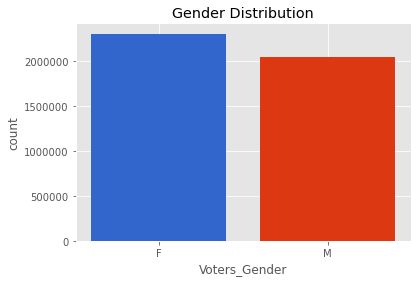

In [ ]:
plt.ticklabel_format(style='plain')
plt.bar(x=py_voters_gender['Voters_Gender'],
        height=py_voters_gender['count'],
       color=colors);

plt.title('Gender Distribution');
plt.ylabel("count");
plt.xlabel('Voters_Gender');

Let's navigate more about the attendance to general 2020 election.

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql import Window

def attendance(data, grouping_col):
    total_voters = data.count()
    w = Window.partitionBy(grouping_col)

    df_output = data.groupBy('general_2020', grouping_col).agg(F.count(grouping_col).alias('count'))
    df_output = df_output.withColumn('segment_total', F.sum('count').over(w))
    df_output = df_output.withColumn('rate of all', F.round(F.col('count') / total_voters, 2))
    df_output = df_output.withColumn('rate of segment', F.round(F.col('count') / F.col('segment_total'), 2))

    return df_output

In [ ]:
general_2020_voters_gender = attendance(voter_data_MA, 'Voters_Gender')

# general_2020_voters_gender.show()
py_general_2020_voters_gender = general_2020_voters_gender.toPandas()
# py_general_2020_voters_gender.head()

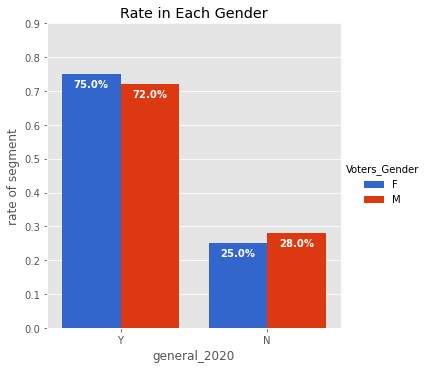

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='Voters_Gender', kind='bar', data=py_general_2020_voters_gender, palette=color_pallette, saturation=1);

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.1f}%' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold')
    ax.margins(y=0.2)

plt.title('Rate in Each Gender')
plt.show()

Female tends to attend more than male. Aound 3% higher than male.

#### B. What is the highest level of education for voters in the dataset?
Most Voters Seems to Carry a Bachelors Degree followed by a Highschool Diploma 

In [ ]:
import pyspark.sql.functions as F

education = voter_data_MA.groupBy("CommercialData_Education").agg(F.count("CommercialData_Education").alias("count")).orderBy(F.desc('count'))
education.show()
py_education = education.toPandas()
py_education.head()

+------------------------+-------+
|CommercialData_Education|  count|
+------------------------+-------+
|                        |1482152|
|    Bach Degree - Ext...| 578628|
|    HS Diploma - Extr...| 399917|
|    Some College - Li...| 397088|
|    Grad Degree - Ext...| 348574|
|    Bach Degree - Likely| 338428|
|    Grad Degree - Likely| 314223|
|     HS Diploma - Likely| 280077|
|    Less than HS Dipl...| 110469|
|    Some College -Ext...| 107169|
|    Vocational Techni...|   3549|
|    Less than HS Dipl...|    467|
+------------------------+-------+



,CommercialData_Education,count
0,,1482152
1,Bach Degree - Extremely Likely,578628
2,HS Diploma - Extremely Likely,399917
3,Some College - Likely,397088
4,Grad Degree - Extremely Likely,348574


The top most data does not have any category. So, remove empty responses. For the following analysis, if there is empty response we will remove them.

In [ ]:
import pyspark.sql.functions as F

education = voter_data_MA\
    .select('CommercialData_Education')\
    .where('CommercialData_Education != ""')\
    .groupBy("CommercialData_Education")\
    .agg(F.count("CommercialData_Education").alias("count"))\
    .orderBy(F.desc('count'))
education.show()
py_education = education.toPandas()
py_education.head()

+------------------------+------+
|CommercialData_Education| count|
+------------------------+------+
|    Bach Degree - Ext...|578628|
|    HS Diploma - Extr...|399917|
|    Some College - Li...|397088|
|    Grad Degree - Ext...|348574|
|    Bach Degree - Likely|338428|
|    Grad Degree - Likely|314223|
|     HS Diploma - Likely|280077|
|    Less than HS Dipl...|110469|
|    Some College -Ext...|107169|
|    Vocational Techni...|  3549|
|    Less than HS Dipl...|   467|
+------------------------+------+



,CommercialData_Education,count
0,Bach Degree - Extremely Likely,578628
1,HS Diploma - Extremely Likely,399917
2,Some College - Likely,397088
3,Grad Degree - Extremely Likely,348574
4,Bach Degree - Likely,338428


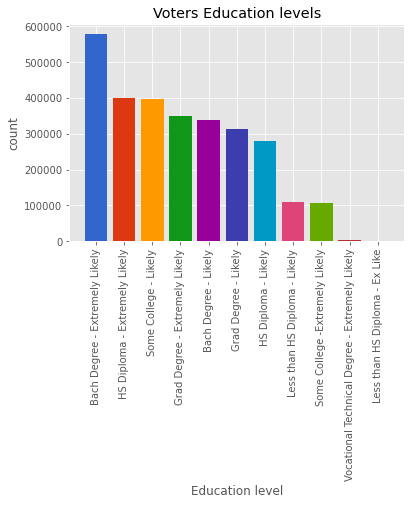

In [ ]:
plt.bar(x=py_education['CommercialData_Education'],
        height=py_education['count'],
       color=colors);

plt.title('Voters Education levels');
plt.ylabel('count');
plt.xlabel('Education level');
plt.xticks(rotation=90);

Let's check  attendance for each segment.

In [ ]:
general_2020_education = attendance(voter_data_MA, 'CommercialData_Education')

# general_2020_education.show()
py_general_2020_education = general_2020_education.toPandas()
# py_general_2020_education.head()

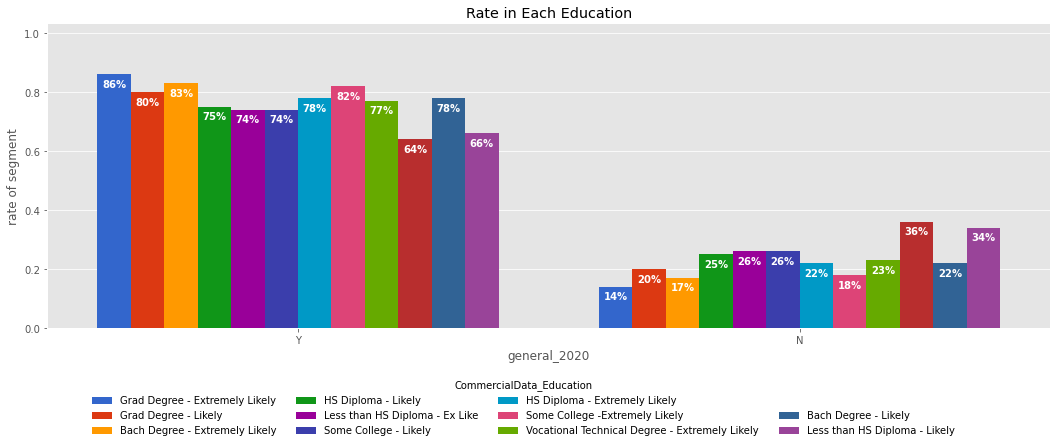

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='CommercialData_Education', kind='bar', data=py_general_2020_education, palette=color_pallette, saturation=1, height=5, aspect=3);
sns.move_legend(g, loc='lower center', ncol=4, bbox_to_anchor=(0.4, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Rate in Each Education');
plt.show();

Higher diploma tends to attend more than lower one.

#### C. What is the ethnic diversity of the voters?
The Most Common Ethnicity is the European ethnicity represneting the majority of the voters.

In [ ]:
import pyspark.sql.functions as F

ethnicity_total = voter_data_MA.count()

ethnicity = voter_data_MA\
    .groupBy("EthnicGroups_EthnicGroup1Desc")\
    .agg(F.count("EthnicGroups_EthnicGroup1Desc").alias("count"))\
    .orderBy(F.desc('count'))

ethnicity = ethnicity.withColumn('share', F.round(F.col('count')/ethnicity_total * 100, 1))
# ethnicity.show()

py_ethnicity = ethnicity.toPandas()
# py_ethnicity.head()

As mentioned above, we will exclude empty response data.

In [ ]:
# remove empty response
import pyspark.sql.functions as F

ethnicity_total = voter_data_MA\
    .select('EthnicGroups_EthnicGroup1Desc')\
    .where('EthnicGroups_EthnicGroup1Desc != ""')\
    .count()

ethnicity = voter_data_MA\
    .select('EthnicGroups_EthnicGroup1Desc')\
    .where('EthnicGroups_EthnicGroup1Desc != ""')\
    .groupBy("EthnicGroups_EthnicGroup1Desc")\
    .agg(F.count("EthnicGroups_EthnicGroup1Desc").alias("count"))\
    .orderBy(F.desc('count'))

ethnicity = ethnicity.withColumn('share', F.round(F.col('count')/ethnicity_total * 100, 1))
ethnicity.show()

py_ethnicity = ethnicity.toPandas()
py_ethnicity.head()

+-----------------------------+-------+-----+
|EthnicGroups_EthnicGroup1Desc|  count|share|
+-----------------------------+-------+-----+
|                     European|2961179| 75.9|
|         Hispanic and Port...| 479293| 12.3|
|         East and South Asian| 174153|  4.5|
|         Likely African-Am...| 156939|  4.0|
|                        Other| 127401|  3.3|
+-----------------------------+-------+-----+



,EthnicGroups_EthnicGroup1Desc,count,share
0,European,2961179,75.9
1,Hispanic and Portuguese,479293,12.3
2,East and South Asian,174153,4.5
3,Likely African-American,156939,4.0
4,Other,127401,3.3


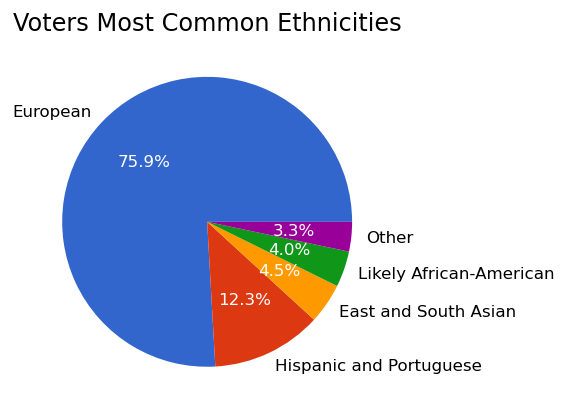

In [ ]:
plt.figure(dpi=120)
_, _, autotexts = plt.pie(py_ethnicity['share'],
       labels=py_ethnicity['EthnicGroups_EthnicGroup1Desc'],
       autopct='%.1f%%',
       colors=colors,
       )

# change autotext color to white
for ins in autotexts:
    ins.set_color('white')
    
plt.title('Voters Most Common Ethnicities')
plt.show()

In [ ]:
general_2020_ethnicity = attendance(voter_data_MA, 'EthnicGroups_EthnicGroup1Desc')

# general_2020_education.show()
py_general_2020_ethnicity = general_2020_ethnicity.toPandas()
# py_general_2020_education.head()

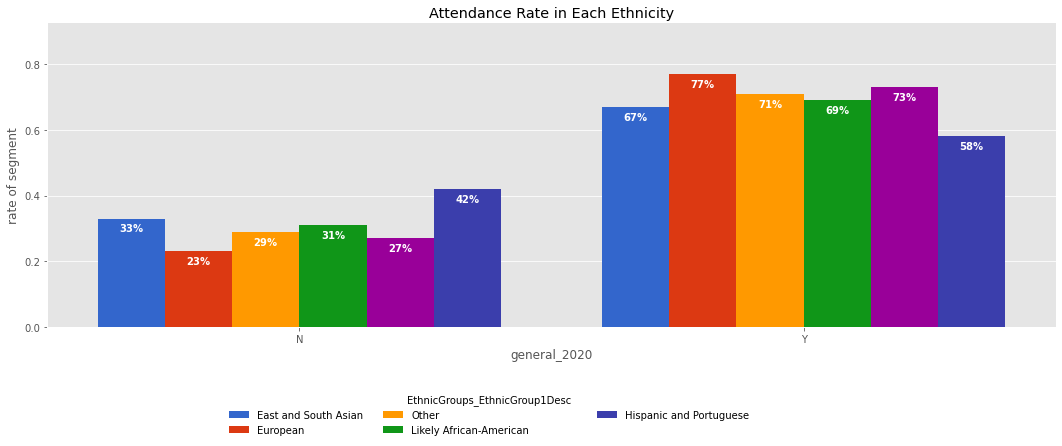

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='EthnicGroups_EthnicGroup1Desc', kind='bar', data=py_general_2020_ethnicity, palette=color_pallette, saturation=1, height=5, aspect=3);
sns.move_legend(g, loc='lower center', ncol=4, bbox_to_anchor=(0.4, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Attendance Rate in Each Ethnicity');
plt.show();

It seems European attend much more than Hispanic and Portugese.

#### D. What is the proportion of different religions among the voters?
The majority of voters in our sample were Christians represented by Catholic first and Protestant second, after that came the Jewish religion and Buddhist religion at 3th and 4th respectively.

In [ ]:
import pyspark.sql.functions as F

religions = voter_data_MA\
    .groupBy("Religions_Description")\
    .agg(F.count("Religions_Description").alias("count"))\
    .orderBy(F.desc('count'))
# religions.show()
py_religions = religions.toPandas()
# py_religions.head()

In [ ]:
# remove empty response
import pyspark.sql.functions as F

religions = voter_data_MA\
    .select('Religions_Description')\
    .where('Religions_Description != ""')\
    .groupBy("Religions_Description")\
    .agg(F.count("Religions_Description").alias("count"))\
    .orderBy(F.desc('count'))
religions.show()
py_religions = religions.toPandas()
py_religions.head()

+---------------------+------+
|Religions_Description| count|
+---------------------+------+
|             Catholic|885879|
|           Protestant|862643|
|               Jewish|178438|
|             Buddhist| 41328|
|     Eastern Orthodox| 30213|
|              Islamic| 21059|
|       Greek Orthodox| 17998|
|                Hindu| 15431|
|            Christian| 13326|
|               Shinto|  3769|
|             Lutheran|  1093|
|                 Sikh|   483|
|               Mormon|    34|
+---------------------+------+



,Religions_Description,count
0,Catholic,885879
1,Protestant,862643
2,Jewish,178438
3,Buddhist,41328
4,Eastern Orthodox,30213


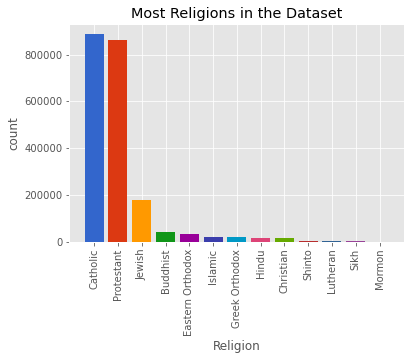

In [ ]:
plt.bar(x=py_religions['Religions_Description'],
        height=py_religions['count'],
       color=colors);

plt.title('Most Religions in the Dataset');
plt.ylabel('count');
plt.xlabel('Religion');
plt.xticks(rotation=90);

In [ ]:
general_2020_religion = attendance(voter_data_MA, 'Religions_Description')

# general_2020_religion.show()
py_general_2020_religion = general_2020_religion.toPandas()
# py_general_2020_religion.head()

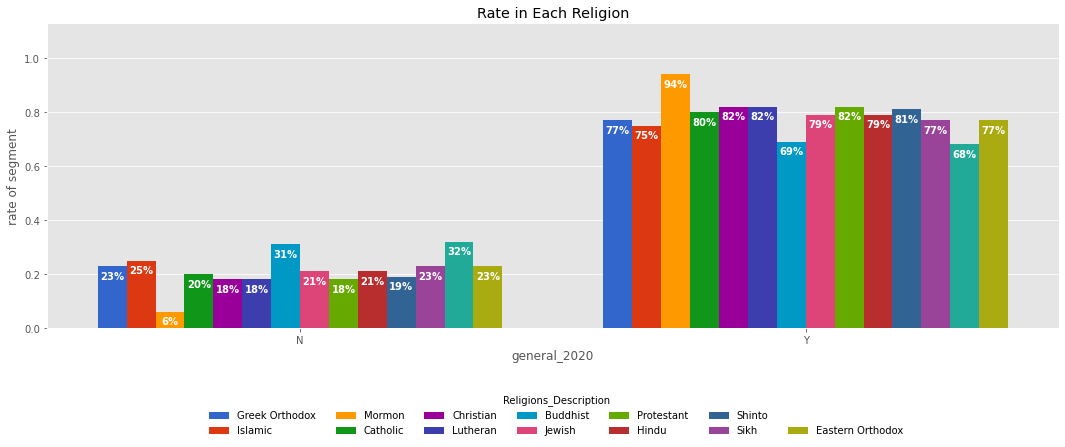

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='Religions_Description', kind='bar', data=py_general_2020_religion, palette=color_pallette, saturation=1, height=5, aspect=3);
sns.move_legend(g, loc='lower center', ncol=7, bbox_to_anchor=(0.47, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Rate in Each Religion');
plt.show();

Mormon is the top place and Sikh and Buddhist took low.

#### E. What is the Marital Status breakdown of the voters?
The majority of voters are married compared to being in a non-traditional relationship.

In [ ]:
import pyspark.sql.functions as F

merital_status = voter_data_MA\
    .groupBy("MaritalStatus_Description")\
    .agg(F.count("MaritalStatus_Description").alias("count"))\
    .orderBy(F.desc('count'))
# merital_status.show()
py_merital_status = merital_status.toPandas()
# py_merital_status.head()

In [ ]:
import pyspark.sql.functions as F

merital_status = voter_data_MA\
    .select('MaritalStatus_Description')\
    .where('MaritalStatus_Description != ""')\
    .groupBy("MaritalStatus_Description")\
    .agg(F.count("MaritalStatus_Description").alias("count"))\
    .orderBy(F.desc('count'))
merital_status.show()
py_merital_status = merital_status.toPandas()
py_merital_status.head()

+-------------------------+-------+
|MaritalStatus_Description|  count|
+-------------------------+-------+
|                  Married|1469771|
|          Non-Traditional| 473336|
+-------------------------+-------+



,MaritalStatus_Description,count
0,Married,1469771
1,Non-Traditional,473336


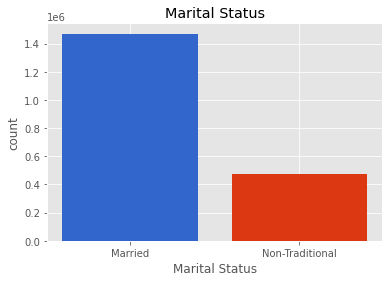

In [ ]:
plt.bar(x=py_merital_status['MaritalStatus_Description'],
        height=py_merital_status['count'],
       color=colors);

plt.title('Marital Status');
plt.ylabel('Count');
plt.xlabel('Marital Status');

In [ ]:
general_2020_merital_status = attendance(voter_data_MA.where('MaritalStatus_Description != ""'), 'MaritalStatus_Description')

# general_2020_merital_status.show()
py_general_2020_merital_status = general_2020_merital_status.toPandas()
# py_general_2020_merital_status.head()

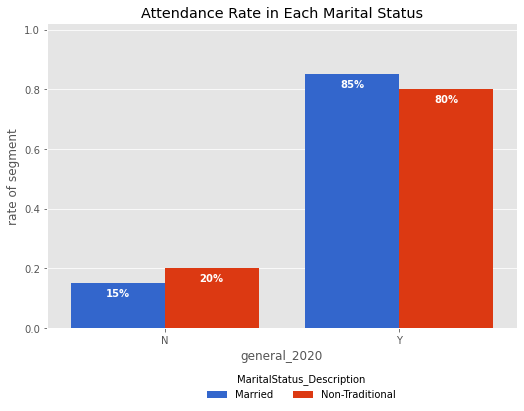

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='MaritalStatus_Description', kind='bar', data=py_general_2020_merital_status, palette=color_pallette, saturation=1, height=5, aspect=1.5);
sns.move_legend(g, loc='lower center', ncol=4, bbox_to_anchor=(0.47, -0.1));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Attendance Rate in Each Marital Status');
plt.show();

Married voters are tend to attend more.

## 2. Which cities have the greatest number of voters?

In [ ]:
import pyspark.sql.functions as F

voters_by_city = voter_data_MA\
    .select('City')\
    .where('City != ""')\
    .groupBy("City")\
    .agg(F.count("City").alias("count"))\
    .orderBy(F.desc('count'))
    
voters_by_city.show(5)
py_voters_by_city = voters_by_city.toPandas()
py_voters_by_city.head()

+----------------+------+
|            City| count|
+----------------+------+
|     BOSTON CITY|374522|
|  WORCESTER CITY|100919|
|SPRINGFIELD CITY| 96000|
|  CAMBRIDGE CITY| 59771|
|     QUINCY CITY| 58581|
+----------------+------+
only showing top 5 rows



,City,count
0,BOSTON CITY,374522
1,WORCESTER CITY,100919
2,SPRINGFIELD CITY,96000
3,CAMBRIDGE CITY,59771
4,QUINCY CITY,58581


In [ ]:
import pyspark.sql.functions as F

voters_by_city = voter_data_MA\
    .select('City')\
    .where('City != ""')\
    .withColumn('City', F.expr("substring(City, 1, length(City)-5)"))\
    .groupBy("City")\
    .agg(F.count("City").alias("count"))\
    .orderBy(F.desc('count'))
    
voters_by_city.show(5)
py_voters_by_city = voters_by_city.toPandas()
py_voters_by_city.head()

+-----------+------+
|       City| count|
+-----------+------+
|     BOSTON|374522|
|  WORCESTER|100919|
|SPRINGFIELD| 96000|
|  CAMBRIDGE| 59771|
|     QUINCY| 58581|
+-----------+------+
only showing top 5 rows



,City,count
0,BOSTON,374522
1,WORCESTER,100919
2,SPRINGFIELD,96000
3,CAMBRIDGE,59771
4,QUINCY,58581


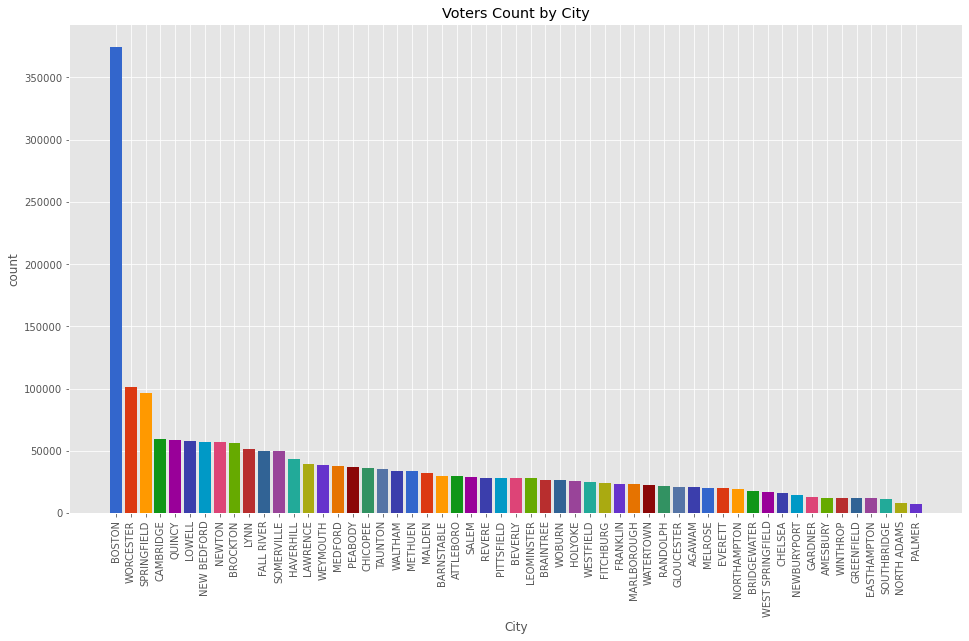

In [ ]:
plt.figure(figsize=(16.0, 9.0))
plt.bar(x=py_voters_by_city['City'],
        height=py_voters_by_city['count'],
       color=colors);

plt.title('Voters Count by City');
plt.ylabel('Count');
plt.xlabel('City');
plt.xticks(rotation=90);

Boston seems to have the greatest number of voters, with a significant difference compared to the cities following it.

In [ ]:
general_2020_city = attendance(voter_data_MA.where('City != ""').withColumn('City', F.expr("substring(City, 1, length(City)-5)")), 'City')

# general_2020_city.show()
py_general_2020_city = general_2020_city.toPandas()
# py_general_2020_city.head()

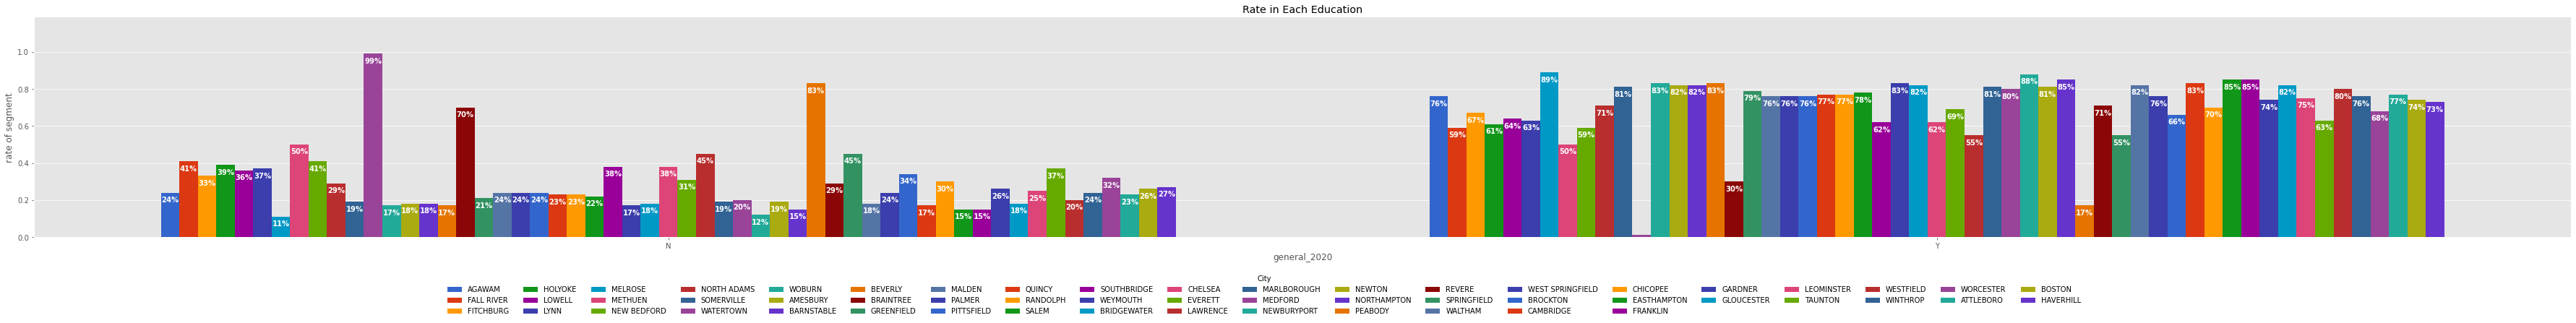

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='City', kind='bar', data=py_general_2020_city, palette=color_pallette, saturation=1, height=5, aspect=10);
sns.move_legend(g, loc='lower center', ncol=20, bbox_to_anchor=(0.47, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Rate in Each Education');
plt.show();

Voters in Watertown, Peabody, and Northadams tend NOT to participate.

## 3. Which counties have the greatest number of voters?

In [ ]:
import pyspark.sql.functions as F

voters_by_county = voter_data_MA\
    .select('COUNTY')\
    .where('COUNTY != ""')\
    .groupBy("COUNTY")\
    .agg(F.count("COUNTY").alias("count"))\
    .orderBy(F.desc('count'))
    
voters_by_county.show(5)
py_voters_by_county = voters_by_county.toPandas()
py_voters_by_county.head()

+---------+-------+
|   COUNTY|  count|
+---------+-------+
|MIDDLESEX|1003309|
|WORCESTER| 526756|
|    ESSEX| 514294|
|  NORFOLK| 477598|
|  SUFFOLK| 430956|
+---------+-------+
only showing top 5 rows



,COUNTY,count
0,MIDDLESEX,1003309
1,WORCESTER,526756
2,ESSEX,514294
3,NORFOLK,477598
4,SUFFOLK,430956


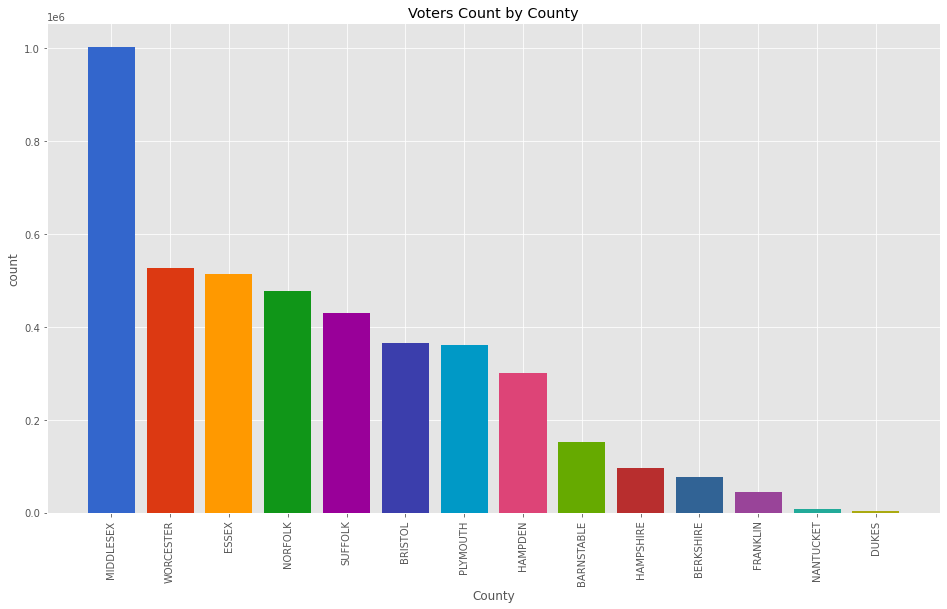

In [ ]:
plt.figure(figsize=(16.0, 9.0))
plt.bar(x=py_voters_by_county['COUNTY'],
        height=py_voters_by_county['count'],
       color=colors);

plt.title('Voters Count by County');
plt.ylabel('Count');
plt.xlabel('County');
plt.xticks(rotation=90);

## 4. Which range of Household Income are most voters in?

In [ ]:
import pyspark.sql.functions as F

voters_by_hh_income = voter_data_MA\
    .groupBy("CommercialData_EstimatedHHIncome")\
    .agg(F.count("CommercialData_EstimatedHHIncome").alias("count"))\
    .orderBy(F.desc('count'))
# voters_by_hh_income.show()
py_voters_by_hh_income = voters_by_hh_income.toPandas()
# py_voters_by_hh_income.head()

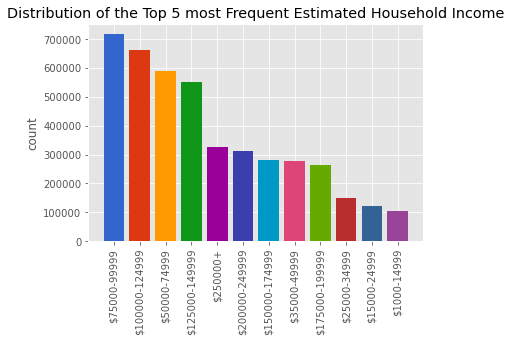

In [ ]:
plt.bar(x=py_voters_by_hh_income['CommercialData_EstimatedHHIncome'],
        height=py_voters_by_hh_income['count'],
       color=colors);

plt.title('Distribution of the Top 5 most Frequent Estimated Household Income');
plt.ylabel('Count');
plt.xticks(rotation=90);

In [ ]:
import pyspark.sql.functions as F

voters_by_hh_income_total = voter_data_MA\
    .count()

voters_by_hh_income = voter_data_MA\
    .groupBy("CommercialData_EstimatedHHIncome")\
    .agg(F.count("CommercialData_EstimatedHHIncome").alias("count"))\
    .orderBy(F.desc('count'))

voters_by_hh_income = voters_by_hh_income.withColumn('share', F.round(F.col('count')/voters_by_hh_income_total * 100, 1))
# voters_by_hh_income.show()

py_voters_by_hh_income = voters_by_hh_income.toPandas()
# py_voters_by_hh_income.head()

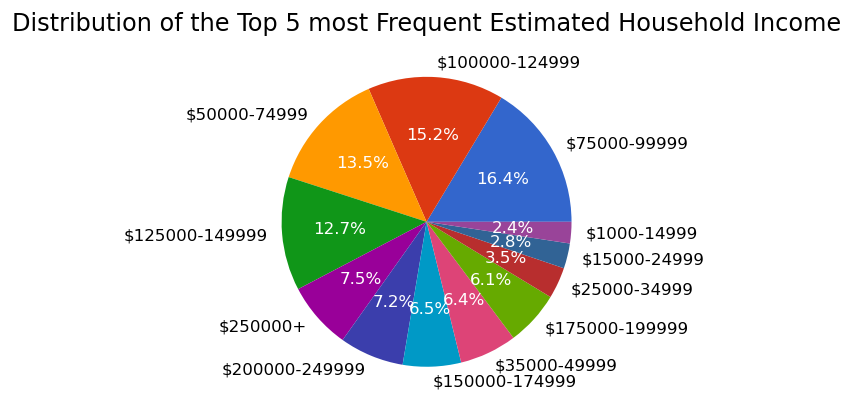

In [ ]:
plt.figure(dpi=120)
_, _, autotexts = plt.pie(py_voters_by_hh_income['share'],
       labels=py_voters_by_hh_income['CommercialData_EstimatedHHIncome'],
       autopct='%.1f%%',
       colors=colors,
       )

# change autotext color to white
for ins in autotexts:
    ins.set_color('white')
    
plt.title('Distribution of the Top 5 most Frequent Estimated Household Income')
plt.show()

Most Voters lie between the 50,000 to 150,0000  range almost evenly distributed with the majority of them lying in the  75,000 - 99,000 range.

In [ ]:
general_2020_income = attendance(voter_data_MA, 'CommercialData_EstimatedHHIncome')

# general_2020_income.show()
py_general_2020_income = general_2020_income.toPandas()
# py_general_2020_income.head()

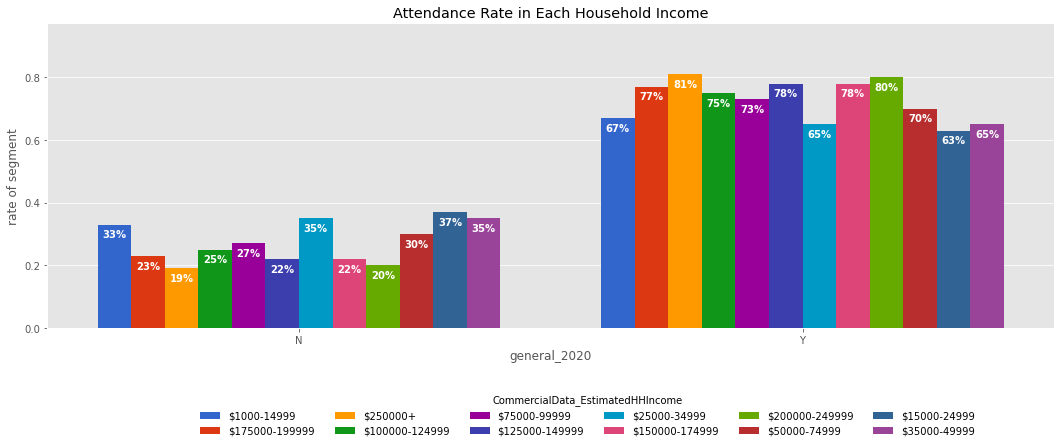

In [ ]:
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='CommercialData_EstimatedHHIncome', kind='bar', data=py_general_2020_income, palette=color_pallette, saturation=1, height=5, aspect=3);
sns.move_legend(g, loc='lower center', ncol=6, bbox_to_anchor=(0.47, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Attendance Rate in Each Household Income');
plt.show();

Voters less than $50,000 Household income have less participation

## 5. Create a heatmap of active voters and voter affiliation in MA

First, we checked how many voters are active within the dataset.

In [ ]:
voter_data_MA.select('Voters_Active').distinct().show(10)

+-------------+
|Voters_Active|
+-------------+
|            A|
|            I|
+-------------+



The voters are divied into Active and Inactive voters. Let's see the counts and rates of them.

In [ ]:
#Check the counts and rates of active and inactive voters respectively

total_voters_count = voter_data_MA.count()
active_voters = voter_data_MA.where(col('Voters_Active') == 'A')
active_voters_count = active_voters.count()
active_voters_rate = active_voters_count / total_voters_count
inactive_voters = voter_data_MA.where(col('Voters_Active') == 'I')
inactive_voters_count = inactive_voters.count()

print('Count of Total Voters:', total_voters_count)

print('Count of Active Voters:', active_voters.count())
print('Rate of Active Voters:', (active_voters_count / total_voters_count))


print('Count of Inactive Voters:', inactive_voters.count())
print('Rate of Inactive Voters:', inactive_voters_count / total_voters_count)


Count of Total Voters: 4360741
Count of Active Voters: 4024114
Rate of Active Voters: 0.9228050920703614
Count of Inactive Voters: 336627
Rate of Inactive Voters: 0.07719490792963857


It looks like over 90% of voters are Active voters. Then let's investigate the party composition of voters.

In [ ]:
voter_data_MA.select(col('Parties_Description')).distinct().show()

+--------------------+
| Parties_Description|
+--------------------+
|        Constitution|
|          Republican|
|American Independent|
|               Other|
|         Libertarian|
|               Green|
|         Natural Law|
|              Reform|
|             Rainbow|
|         Prohibition|
|        Conservative|
|Working Family Party|
|          Democratic|
|           Socialist|
|        Non-Partisan|
+--------------------+



There are 15 categories of parties including Non-partisan. We can see how many voters are in each party affilitation and rate.

In [ ]:
inactive_voters_total = inactive_voters.count()
active_voters_total = active_voters.count()

df_heatmap = \
    voter_data_MA.groupBy('Voters_Active', 'Parties_Description')\
        .count()\
        .withColumn('rate', 
                    when(col('Voters_Active') == 'A', col('count') / active_voters_total)
                    .otherwise(col('count') / inactive_voters_total))\
        .orderBy(['Voters_Active', 'count', 'rate'], ascending = False)

In [ ]:
df_heatmap.withColumn('rate', round(col('rate'), scale = 2)).show(30)

+-------------+--------------------+-------+----+
|Voters_Active| Parties_Description|  count|rate|
+-------------+--------------------+-------+----+
|            I|        Non-Partisan| 187437|0.56|
|            I|          Democratic| 113102|0.34|
|            I|          Republican|  29455|0.09|
|            I|               Other|   3624|0.01|
|            I|         Libertarian|   1843|0.01|
|            I|               Green|    566| 0.0|
|            I|        Conservative|    214| 0.0|
|            I|American Independent|    166| 0.0|
|            I|           Socialist|    100| 0.0|
|            I|Working Family Party|     65| 0.0|
|            I|        Constitution|     23| 0.0|
|            I|         Natural Law|     11| 0.0|
|            I|              Reform|     10| 0.0|
|            I|             Rainbow|      9| 0.0|
|            I|         Prohibition|      2| 0.0|
|            A|        Non-Partisan|2313198|0.57|
|            A|          Democratic|1265443|0.31|


Among active voters, around 57% is Non-Partsan, 31% are Democratic, 1% are Republican. We can see this in the heatmap as well.

In [ ]:
df_heatmap_pandas = df_heatmap.toPandas()
df_heatmap_pandas = df_heatmap_pandas.pivot('Voters_Active', 'Parties_Description', 'count')
df_heatmap_pandas

Parties_Description,American Independent,Conservative,Constitution,Democratic,Green,Libertarian,Natural Law,Non-Partisan,Other,Prohibition,Rainbow,Reform,Republican,Socialist,Working Family Party
Voters_Active,,,,,,,,,,,,,,,
A,2507,3261,264,1265443,3181,15034,43,2313198,22232,14,75,118,396976,1109,659
I,166,214,23,113102,566,1843,11,187437,3624,2,9,10,29455,100,65


<AxesSubplot:xlabel='Parties_Description', ylabel='Voters_Active'>

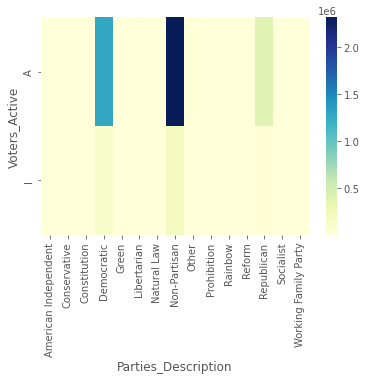

In [ ]:
sns.heatmap(df_heatmap_pandas, cmap='YlGnBu')

As we can observe above chart, among active voters, Non-partision is the top position followed by Democratic and Republican.
Which is consistant with the table data

## 6. If voter votes in primary, will they vote in general election?
It seems that around 5 to 10% of people vote both primary and general except in 2018 and 2020, In 2018, around 20% voted for both. In 2020, around 32% voted for both. Increase of voting is a good signal.

People tends to vote more in general election than primary election.

In [ ]:
#Subsetting Primary elections
cols_primary = ['Primary_2000',
 'Primary_2002',
 'Primary_2004',
 'Primary_2006',
 'Primary_2008',
 'Primary_2010',
 'Primary_2012',
 'Primary_2014',
 'Primary_2016',
 'Primary_2018',
 'Primary_2020',
 'Primary_2022']

In [ ]:
#Subsetting General elections
cols_general = [ 'General_2000',
 'General_2002',
 'General_2004',
 'General_2006',
 'General_2008',
 'General_2010',
 'General_2012',
 'General_2014',
 'General_2016',
 'General_2018',
 'General_2020',
 'General_2022']

In [ ]:
cols_p_g = list(zip(cols_primary, cols_general))

In [ ]:
voter_data_MA.select(cols_primary).show(10)

+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|Primary_2000|Primary_2002|Primary_2004|Primary_2006|Primary_2008|Primary_2010|Primary_2012|Primary_2014|Primary_2016|Primary_2018|Primary_2020|Primary_2022|
+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+
|           N|           N|           N|           N|           N|           N|           N|           N|           Y|           N|           N|           N|
|           N|           N|           N|           N|           N|           N|           N|           Y|           Y|           Y|           Y|           N|
|           N|           Y|           N|           Y|           Y|           N|           N|           N|           N|           Y|           Y|           N|
|           N|           N|           N|           N

In [ ]:
voter_both_p_g = voter_data_MA.select(
    [sum(when((col(p) == 'Y') & (col(g) == 'Y'), 1)
     .otherwise(0)).alias(str(p).split(sep = '_')[1]) for p, g in cols_p_g])
voter_both_p_g.show()

voter_only_p = voter_data_MA.select(
    [sum(when((col(p) == 'Y') & (col(g) == 'N'), 1)
     .otherwise(0)).alias(str(p).split(sep = '_')[1]) for p, g in cols_p_g])
voter_only_p.show()

voter_only_g = voter_data_MA.select(
    [sum(when((col(p) == 'N') & (col(g) == 'Y'), 1)
     .otherwise(0)).alias(str(p).split(sep = '_')[1]) for p, g in cols_p_g])
voter_only_g.show()

voter_neigher_p_g = voter_data_MA.select(
    [sum(when((col(p) == 'N') & (col(g) == 'N'), 1)
     .otherwise(0)).alias(str(p).split(sep = '_')[1]) for p, g in cols_p_g])
voter_neigher_p_g.show()

+------+------+------+------+------+------+------+------+------+------+-------+----+
|  2000|  2002|  2004|  2006|  2008|  2010|  2012|  2014|  2016|  2018|   2020|2022|
+------+------+------+------+------+------+------+------+------+------+-------+----+
|160174|571878|257504|634977|373043|499877|382079|552768|315369|843845|1388312|   0|
+------+------+------+------+------+------+------+------+------+------+-------+----+



+----+-----+----+-----+----+-----+----+-----+----+-----+------+----+
|2000| 2002|2004| 2006|2008| 2010|2012| 2014|2016| 2018|  2020|2022|
+----+-----+----+-----+----+-----+----+-----+----+-----+------+----+
|5067|41603|6572|30040|6585|21596|6871|26473|6852|38224|101358|   0|
+----+-----+----+-----+----+-----+----+-----+----+-----+------+----+



+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+----+
|   2000|  2002|   2004|  2006|   2008|   2010|   2012|   2014|   2016|   2018|   2020|2022|
+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+----+
|1291211|729273|1564249|913730|1793853|1230278|2058340|1251570|2574615|1635190|1832219|   0|
+-------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+----+



+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|   2000|   2002|   2004|   2006|   2008|   2010|   2012|   2014|   2016|   2018|   2020|   2022|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|2904289|3017987|2532416|2781994|2187260|2608990|1913451|2529930|1463905|1843482|1038852|4360741|
+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+



There is no transpose function in PySpark. And this dataframe is so small that we simply transform to Pandas to merge them.

In [ ]:
voter_both_p_g_pandas = voter_both_p_g.toPandas()
voter_only_p_pandas = voter_only_p.toPandas()
voter_only_g_pandas = voter_only_g.toPandas()
voter_neigher_p_g_pandas = voter_neigher_p_g.toPandas()

In [ ]:
voter_both_p_g_pandas = voter_both_p_g_pandas.transpose()
voter_both_p_g_pandas.columns = ['both']

voter_only_p_pandas = voter_only_p_pandas.transpose()
voter_only_p_pandas.columns = ['only primary']

voter_only_g_pandas = voter_only_g_pandas.transpose()
voter_only_g_pandas.columns = ['only general']

voter_neigher_p_g_pandas = voter_neigher_p_g_pandas.transpose()
voter_neigher_p_g_pandas.columns = ['neither']

In [ ]:
voter_both_p_g_pandas.reset_index(inplace=True)
voter_only_p_pandas.reset_index(inplace=True)
voter_only_g_pandas.reset_index(inplace=True)
voter_neigher_p_g_pandas.reset_index(inplace=True)

In [ ]:
voter_p_g_status_pandas = \
    voter_both_p_g_pandas.merge(voter_only_p_pandas, left_on='index', right_on='index')\
        .merge(voter_only_g_pandas, left_on='index', right_on='index')\
        .merge(voter_neigher_p_g_pandas, left_on='index', right_on='index')

In [ ]:
voter_p_g_status_pandas['total'] = \
    voter_p_g_status_pandas['both'] + voter_p_g_status_pandas['only primary'] + \
    voter_p_g_status_pandas['only general'] + voter_p_g_status_pandas['neither']
voter_p_g_status_pandas.rename(columns={'index': 'year'}, inplace=True)
voter_p_g_status_pandas

,year,both,only primary,only general,neither,total
0,2000,160174,5067,1291211,2904289,4360741
1,2002,571878,41603,729273,3017987,4360741
2,2004,257504,6572,1564249,2532416,4360741
3,2006,634977,30040,913730,2781994,4360741
4,2008,373043,6585,1793853,2187260,4360741
5,2010,499877,21596,1230278,2608990,4360741
6,2012,382079,6871,2058340,1913451,4360741
7,2014,552768,26473,1251570,2529930,4360741
8,2016,315369,6852,2574615,1463905,4360741
9,2018,843845,38224,1635190,1843482,4360741


Now we can transform to Pyspark.

In [ ]:
voter_p_g_status = spark.createDataFrame(voter_p_g_status_pandas)

In [ ]:
voter_p_g_status.show()

+----+-------+------------+------------+-------+-------+
|year|   both|only primary|only general|neither|  total|
+----+-------+------------+------------+-------+-------+
|2000| 160174|        5067|     1291211|2904289|4360741|
|2002| 571878|       41603|      729273|3017987|4360741|
|2004| 257504|        6572|     1564249|2532416|4360741|
|2006| 634977|       30040|      913730|2781994|4360741|
|2008| 373043|        6585|     1793853|2187260|4360741|
|2010| 499877|       21596|     1230278|2608990|4360741|
|2012| 382079|        6871|     2058340|1913451|4360741|
|2014| 552768|       26473|     1251570|2529930|4360741|
|2016| 315369|        6852|     2574615|1463905|4360741|
|2018| 843845|       38224|     1635190|1843482|4360741|
|2020|1388312|      101358|     1832219|1038852|4360741|
|2022|      0|           0|           0|4360741|4360741|
+----+-------+------------+------------+-------+-------+



In [ ]:
total_voters = voter_p_g_status.select('total').first()['total']
total_voters

4360741

In [ ]:
voter_p_g_status = voter_p_g_status.withColumn('both_rate', col('both') / total_voters)\
    .withColumn('only primary_rate', col('only primary') / total_voters)\
    .withColumn('only general_rate', col('only general') / total_voters)\
    .withColumn('neither_rate', col('neither') / total_voters)

In [ ]:
voter_p_g_status.select(['year', 
                         'both', round('both_rate', 3).alias('both_rate'), 
                         'only primary', round('only primary_rate', 3).alias('only primary_rate'),
                         'only general', round('only general_rate', 3).alias('only general_rate'),
                         'neither', round('neither_rate', 3).alias('neither_rate'),
                        ]).show()

+----+-------+---------+------------+-----------------+------------+-----------------+-------+------------+
|year|   both|both_rate|only primary|only primary_rate|only general|only general_rate|neither|neither_rate|
+----+-------+---------+------------+-----------------+------------+-----------------+-------+------------+
|2000| 160174|    0.037|        5067|            0.001|     1291211|            0.296|2904289|       0.666|
|2002| 571878|    0.131|       41603|             0.01|      729273|            0.167|3017987|       0.692|
|2004| 257504|    0.059|        6572|            0.002|     1564249|            0.359|2532416|       0.581|
|2006| 634977|    0.146|       30040|            0.007|      913730|             0.21|2781994|       0.638|
|2008| 373043|    0.086|        6585|            0.002|     1793853|            0.411|2187260|       0.502|
|2010| 499877|    0.115|       21596|            0.005|     1230278|            0.282|2608990|       0.598|
|2012| 382079|    0.088|    

## 7.  Exploring Food Access Statistics Using Describe

In summary, our intial exploration of the Food Access Index dataset found that the average food access index score for 1600m was 6.48 with a standard deviation of 5.54. On the other hand, the average food access index score for 8000m was almost doubled at 13.53 with a lower standard deviation of 2.96. 

In [ ]:
voter_data_MA.describe(['Mean_Food_Access_Index_for_1600m','Mean_Food_Access_Index_for_8000m']).show()

+-------+--------------------------------+--------------------------------+
|summary|Mean_Food_Access_Index_for_1600m|Mean_Food_Access_Index_for_8000m|
+-------+--------------------------------+--------------------------------+
|  count|                         4360474|                         4360474|
|   mean|               6.477954897528375|              13.530571155076688|
| stddev|              5.5373786987343205|              2.9585187403122295|
|    min|                             0.0|                      0.00820189|
|    max|                            15.0|                            15.0|
+-------+--------------------------------+--------------------------------+



## 8. Which County has the highest and lowest food access on average within both 1600m (1 mile) and 8000m (5 miles)?

Within 8000m (5 miles) it appears Suffolk is the county with the highest access to food while Dukes is the county with the lowest access to food.
Within 1600m (1 mile) it appears Suffolk is the county with the highest access to food while Dukes is the county with the lowest access to food. This is consistent across both the 8000 and 1600m distances.

In [ ]:
# County Food Access Means Within 8000 m (5 miles)
from pyspark.sql.functions import avg, round, col

county_food_access_8000m = voter_data_MA.groupBy("COUNTY").agg(round(avg("Mean_Food_Access_Index_for_8000m"), 2).alias("Food_Access_Mean_8000")).orderBy(col("Food_Access_Mean_8000").desc())
# county_food_access_8000m.show(25)

In [ ]:
# County Food Access Means Within 1600 m (1 mile)
county_food_access_1600m = voter_data_MA.groupBy("COUNTY").agg(round(avg("Mean_Food_Access_Index_for_1600m"), 2).alias("Food_Access_Mean_1600")).orderBy(col("Food_Access_Mean_1600").desc())
# county_food_access_1600m.show(25)

In [ ]:
# join two dataframes and display
combined_county_food_access = county_food_access_1600m.join(county_food_access_8000m, 'COUNTY', 'left').orderBy(col("Food_Access_Mean_1600").desc())
combined_county_food_access.show(25)

+----------+---------------------+---------------------+
|    COUNTY|Food_Access_Mean_1600|Food_Access_Mean_8000|
+----------+---------------------+---------------------+
|   SUFFOLK|                13.55|                14.87|
| MIDDLESEX|                 7.42|                14.48|
|     ESSEX|                 6.63|                13.46|
|   HAMPDEN|                 6.43|                13.25|
|   NORFOLK|                 6.23|                 14.5|
|   BRISTOL|                 5.49|                13.15|
| NANTUCKET|                 4.26|                 9.83|
| WORCESTER|                 4.15|                12.53|
| BERKSHIRE|                 3.53|                 9.86|
|  PLYMOUTH|                 3.47|                12.71|
|BARNSTABLE|                 3.25|                12.76|
| HAMPSHIRE|                 2.91|                11.58|
|  FRANKLIN|                 2.55|                 7.78|
|     DUKES|                  1.4|                 3.88|
+----------+-------------------

In [ ]:
py_combined_county_food_access = combined_county_food_access.toPandas()
py_combined_county_food_access.head()

,COUNTY,Food_Access_Mean_1600,Food_Access_Mean_8000
0,SUFFOLK,13.55,14.87
1,MIDDLESEX,7.42,14.48
2,ESSEX,6.63,13.46
3,HAMPDEN,6.43,13.25
4,NORFOLK,6.23,14.50


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

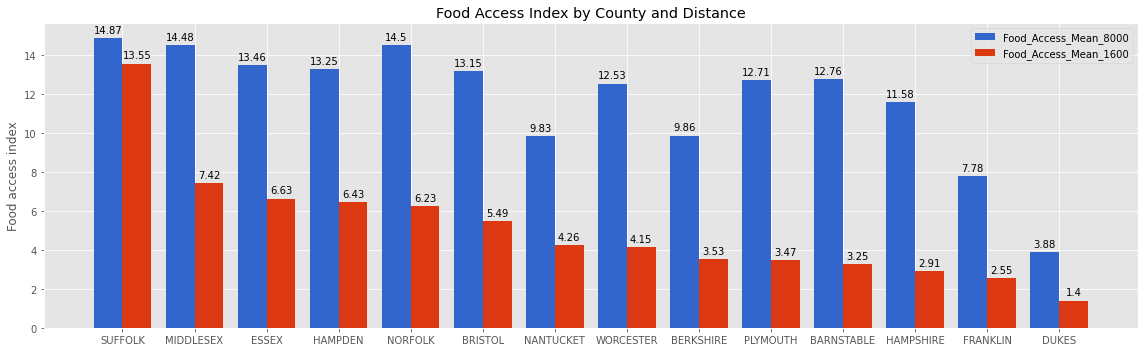

In [ ]:
labels = py_combined_county_food_access['COUNTY'].to_list()
y1 = list(np.array(py_combined_county_food_access['Food_Access_Mean_8000']));
y2 = list(np.array(py_combined_county_food_access['Food_Access_Mean_1600']));

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(16.0, 5.0))

rects1 = ax.bar(x - width/2, y1, width, label='Food_Access_Mean_8000', color=colors[0])
rects2 = ax.bar(x + width/2, y2, width, label='Food_Access_Mean_1600', color=colors[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Food Access Index')
ax.set_title('Food Access Index by County and Distance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Suffolk is the county with an overwhelming higher access to food in the 1600m range while slightly higher than Norfolk in the 8000m range. Dukes has significantly less food access than other counties in both the 8000 and 1600m ranges.

In [ ]:
general_2020_food_index = attendance(voter_data_MA, 'COUNTY')

general_2020_food_index.show()
py_general_2020_food_index = general_2020_food_index.toPandas()
# py_general_2020_food_index.head()

+------------+----------+------+-------------+-----------+---------------+
|general_2020|    COUNTY| count|segment_total|rate of all|rate of segment|
+------------+----------+------+-------------+-----------+---------------+
|           Y|     DUKES|  2448|         3648|        0.0|           0.67|
|           N|     DUKES|  1200|         3648|        0.0|           0.33|
|           N| MIDDLESEX|254775|      1003309|       0.06|           0.25|
|           Y| MIDDLESEX|748534|      1003309|       0.17|           0.75|
|           Y|BARNSTABLE|125892|       151354|       0.03|           0.83|
|           N|BARNSTABLE| 25462|       151354|       0.01|           0.17|
|           Y|     ESSEX|358809|       514294|       0.08|            0.7|
|           N|     ESSEX|155485|       514294|       0.04|            0.3|
|           Y| NANTUCKET|  5690|         7151|        0.0|            0.8|
|           N| NANTUCKET|  1461|         7151|        0.0|            0.2|
|           N|   BRISTOL|

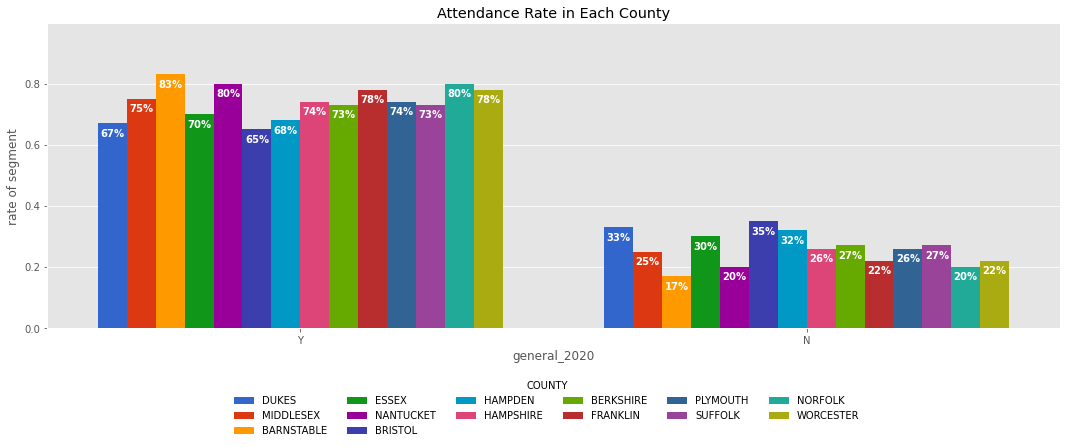

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors);

g = sns.catplot(x='general_2020', y='rate of segment', hue='COUNTY', kind='bar', data=py_general_2020_food_index, palette=color_pallette, saturation=1, height=5, aspect=3);
sns.move_legend(g, loc='lower center', ncol=6, bbox_to_anchor=(0.47, -0.2));

# iterate through axes
for ax in g.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()) * 100:.0f}%' for v in c];
        ax.bar_label(c, labels=labels, label_type='edge', padding=-15, color='white', fontweight='bold');
    ax.margins(y=0.2)

plt.title('Attendance Rate in Each County');
plt.show();

It seems food index does not much related with attendance of voters.

## 9. Which City has the highest access to food within both 1600 meters (1 mile) and 8000 meters (5 miles)?

In [ ]:
# Block Group ID Food Access Means Within 8000 m (5 miles)
from pyspark.sql.functions import avg, round, count, col

city_food_access_8000m = voter_data_MA.groupBy("City", "COUNTY").agg(round(avg("Mean_Food_Access_Index_for_8000m"), 2).alias("Food_Access_Mean_8000")).orderBy(col("Food_Access_Mean_8000").desc()).where('City != ""')
#city_food_access_8000m.head(10)
#city_food_access_8000m.show(25)

In [ ]:
# City Food Access Means Within 1600 m (1 mile)
city_food_access_1600m = voter_data_MA.groupBy("City").agg(round(avg("Mean_Food_Access_Index_for_1600m"), 2).alias("Food_Access_Mean_1600")).orderBy(col("Food_Access_Mean_1600").desc()).where('City != ""')
#city_food_access_1600m.show(25)

In [ ]:
# join two dataframes and display
combined_city_food_access = city_food_access_1600m.join(city_food_access_8000m, 'City', 'left').orderBy(col("Food_Access_Mean_1600").desc())
#combined_city_food_access.show(25)

In [ ]:
py_combined_city_food_access = combined_city_food_access.toPandas()
py_combined_city_food_access.head(5)

,City,Food_Access_Mean_1600,COUNTY,Food_Access_Mean_8000
0,SOMERVILLE CITY,14.80,MIDDLESEX,15.00
1,EVERETT CITY,14.15,MIDDLESEX,14.89
2,CHELSEA CITY,14.14,SUFFOLK,14.82
3,CAMBRIDGE CITY,14.02,MIDDLESEX,15.00
4,BOSTON CITY,13.74,SUFFOLK,14.88


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

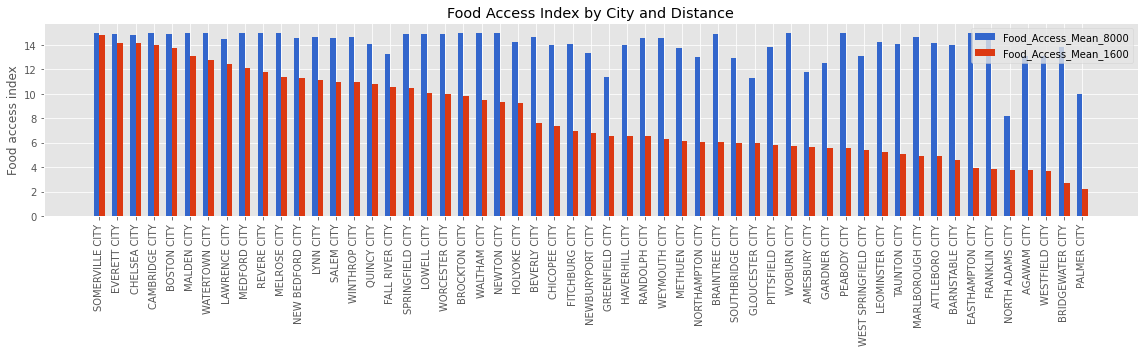

In [ ]:
labels = py_combined_city_food_access['City'].to_list()
y1 = list(np.array(py_combined_city_food_access['Food_Access_Mean_8000']));
y2 = list(np.array(py_combined_city_food_access['Food_Access_Mean_1600']));

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(16.0, 5.0))

rects1 = ax.bar(x - width/2, y1, width, label='Food_Access_Mean_8000', color=colors[0])
rects2 = ax.bar(x + width/2, y2, width, label='Food_Access_Mean_1600', color=colors[1])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Food access index')
ax.set_title('Food Access Index by City and Distance')
ax.set_xticks(x)
plt.xticks(rotation='vertical')
ax.set_xticklabels(labels)
ax.legend()



fig.tight_layout()

plt.show()

In [ ]:
py_combined_city_food_access.head(5)

,City,Food_Access_Mean_1600,COUNTY,Food_Access_Mean_8000
0,SOMERVILLE CITY,14.80,MIDDLESEX,15.00
1,EVERETT CITY,14.15,MIDDLESEX,14.89
2,CHELSEA CITY,14.14,SUFFOLK,14.82
3,CAMBRIDGE CITY,14.02,MIDDLESEX,15.00
4,BOSTON CITY,13.74,SUFFOLK,14.88


In [ ]:
py_combined_city_food_access.tail(5)

,City,Food_Access_Mean_1600,COUNTY,Food_Access_Mean_8000
50,NORTH ADAMS CITY,3.80,BERKSHIRE,8.21
51,AGAWAM CITY,3.73,HAMPDEN,13.10
52,WESTFIELD CITY,3.71,HAMPDEN,13.11
53,BRIDGEWATER CITY,2.67,PLYMOUTH,13.81
54,PALMER CITY,2.23,HAMPDEN,9.95


In [ ]:
#Count of Cities within each County
conuty_grouped_by_cities = voter_data_MA.groupBy("COUNTY").agg(round(count("City"), 2).alias("CountCities")).orderBy(col("CountCities").desc())
conuty_grouped_by_cities.show(25)

+----------+-----------+
|    COUNTY|CountCities|
+----------+-----------+
| MIDDLESEX|    1003309|
| WORCESTER|     526756|
|     ESSEX|     514294|
|   NORFOLK|     477598|
|   SUFFOLK|     430956|
|   BRISTOL|     366281|
|  PLYMOUTH|     360071|
|   HAMPDEN|     301324|
|BARNSTABLE|     151354|
| HAMPSHIRE|      95421|
| BERKSHIRE|      77564|
|  FRANKLIN|      45014|
| NANTUCKET|       7151|
|     DUKES|       3648|
+----------+-----------+



The top 5 cities with the highest food access on average (Somerville, Everett, Chelsea, Cambridge, Boston) within the 1 mile range all fall within two of the top 3 counties with the highest food average (Suffolk and Middlesex). <br>Interestingly enough, not all the top five cities (North Adams, Agawam, Westfield, Bridgewater, Palmer) with the lowest access to food on average fall within the top counties with the lowest access to food (Dukes, Franklin, Nantucket). Plymouth ranks in the to 5 counties with the lowest access to food; however, how can the cities within Hampden rank so lowly when Hampden is a top 4 county with highest access to food? <br>Upon further analysis, this could be explained by: <br>1) Hampden being middle of the pack in terms of number of cities per county, indicating that a couple low ratings may not affect the overall average much <br>2) Out of the top 20 cities with the lowest access to food, 3 of the top 5 fall within Hampden; however, outside of these only one other city is in the top 20. 

## 10. How does food access relate to voting patterns?

At first glance it looks like people who did not vote in general election of '20, '18, '16 — regardless of party — had better access to food. 

In [ ]:
# with all data from voter_data_MA
df_histplot_spark = voter_data_MA\
    .filter((voter_data_MA.Parties_Description == ('Non-Partisan')) \
           | (voter_data_MA.Parties_Description == ('Democratic')) \
            | (voter_data_MA.Parties_Description == ('Republican')))

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
hists_1mile = df_histplot_spark \
    .select("Mean_Food_Access_Index_for_1600m").rdd.flatMap(lambda row: row) \
    .histogram(50)

data_1mile = {
    'bins': hists_1mile[0][:-1],
    'freq': hists_1mile[1]
}

# plt.ticklabel_format(style='plain')
hists_5miles = df_histplot_spark \
    .select("Mean_Food_Access_Index_for_8000m").rdd.flatMap(lambda row: row) \
    .histogram(50)

data_5miles = {
    'bins': hists_5miles[0][:-1],
    'freq': hists_5miles[1]
}

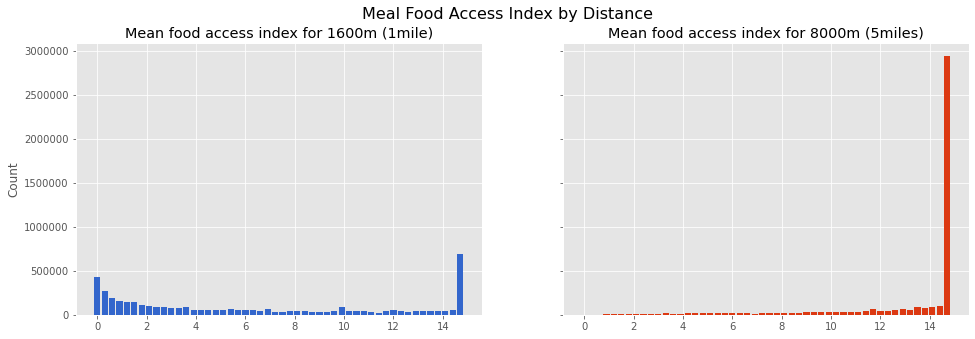

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True);
plt.ticklabel_format(style='plain');

axes[0].bar(x=data_1mile['bins'], height=data_1mile['freq'], width=.25, color=colors[0]);
axes[0].set_title('Mean food access index for 1600m (1mile)');
axes[0].set_ylabel('Count');
# axes[0].set.xlabel('Mean food access index for 1600m (1mile)')
axes[1].bar(x=data_5miles['bins'], height=data_5miles['freq'], width=.25, color=colors[1]);
axes[1].set_title('Mean food access index for 8000m (5miles)');

fig.suptitle('Meal Food Access Index by Distance', fontsize=16);

In [ ]:
from pyspark.sql.functions import avg
py_histplot_1mile_2020 = df_histplot_spark.groupBy('General_2020', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_1600m').alias('Mean_Food_Access_Index_for_1600m')).toPandas()
py_histplot_5miles_2020 = df_histplot_spark.groupBy('General_2020', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_8000m').alias('Mean_Food_Access_Index_for_8000m')).toPandas()
py_histplot_1mile_2018 = df_histplot_spark.groupBy('General_2018', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_1600m').alias('Mean_Food_Access_Index_for_1600m')).toPandas()
py_histplot_5miles_2018 = df_histplot_spark.groupBy('General_2018', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_8000m').alias('Mean_Food_Access_Index_for_8000m')).toPandas()
py_histplot_1mile_2016 = df_histplot_spark.groupBy('General_2016', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_1600m').alias('Mean_Food_Access_Index_for_1600m')).toPandas()
py_histplot_5miles_2016 = df_histplot_spark.groupBy('General_2016', 'Parties_Description').agg(avg('Mean_Food_Access_Index_for_8000m').alias('Mean_Food_Access_Index_for_8000m')).toPandas()

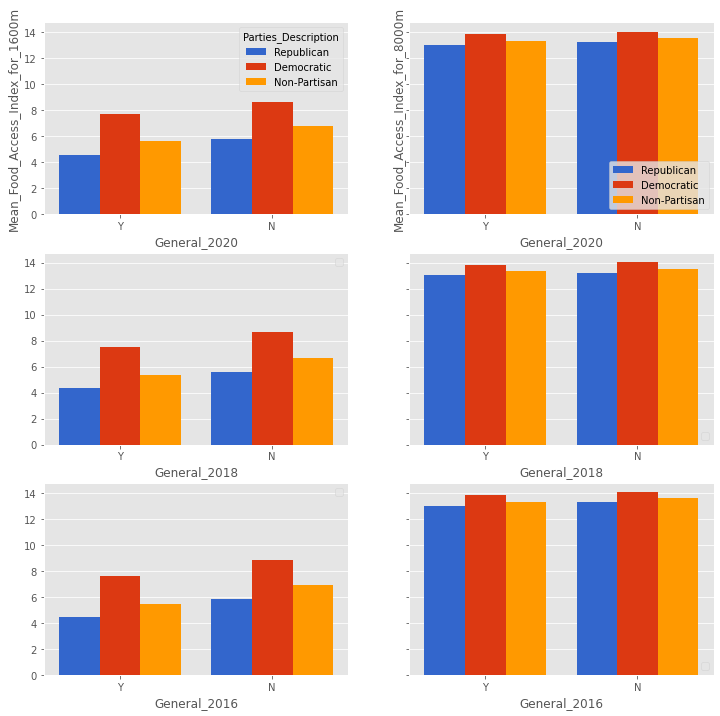

In [ ]:
import seaborn as sns
color_pallette = sns.color_palette(colors[:3]);

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True);

sns.barplot(ax = axes[0, 0], data=py_histplot_1mile_2020, x='General_2020', y='Mean_Food_Access_Index_for_1600m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
sns.barplot(ax = axes[0, 1], data=py_histplot_5miles_2020, x='General_2020', y='Mean_Food_Access_Index_for_8000m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
axes[0, 1].legend(loc='lower right');

sns.barplot(ax = axes[1, 0], data=py_histplot_1mile_2018, x='General_2018', y='Mean_Food_Access_Index_for_1600m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
sns.barplot(ax = axes[1, 1], data=py_histplot_5miles_2018, x='General_2018', y='Mean_Food_Access_Index_for_8000m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
axes[1, 0].legend('');
axes[1, 1].legend('', loc='lower right');
axes[1, 0].set(ylabel='');
axes[1, 1].set(ylabel='');
sns.barplot(ax = axes[2, 0], data=py_histplot_1mile_2016, x='General_2016', y='Mean_Food_Access_Index_for_1600m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
sns.barplot(ax = axes[2, 1], data=py_histplot_5miles_2016, x='General_2016', y='Mean_Food_Access_Index_for_8000m', hue='Parties_Description', order=['Y','N'], palette=color_pallette, saturation=1);
axes[2, 0].legend('');
axes[2, 1].legend('', loc='lower right');
axes[2, 0].set(ylabel='');
axes[2, 1].set(ylabel='');

## 11. How does household income relate to food access?
Based on the barplot, lower and higher income voters had higher food index scores, whereas middle income voters had lower food index scores. 


In [ ]:
# Food Access Means Within 1600 m by income
income_food_access_1600m = voter_data_MA.where((col('Parties_Description') == 'Non-Partisan') | (col('Parties_Description') == 'Republican') | (col('Parties_Description') == 'Democratic')).groupBy('CommercialData_EstimatedHHIncome', 'Parties_Description').agg(round(avg('Mean_Food_Access_Index_for_1600m'), 2).alias('Food_Access_Mean_1600')).orderBy('CommercialData_EstimatedHHIncome', col('Parties_Description').asc())
income_food_access_1600m.show(5)
py_income_food_access_1mile = income_food_access_1600m.toPandas()
py_income_food_access_1mile.head()

+--------------------------------+-------------------+---------------------+
|CommercialData_EstimatedHHIncome|Parties_Description|Food_Access_Mean_1600|
+--------------------------------+-------------------+---------------------+
|                     $1000-14999|         Democratic|                 10.5|
|                     $1000-14999|       Non-Partisan|                 8.75|
|                     $1000-14999|         Republican|                 7.98|
|                  $100000-124999|         Democratic|                  6.7|
|                  $100000-124999|       Non-Partisan|                 4.99|
+--------------------------------+-------------------+---------------------+
only showing top 5 rows



,CommercialData_EstimatedHHIncome,Parties_Description,Food_Access_Mean_1600
0,$1000-14999,Democratic,10.50
1,$1000-14999,Non-Partisan,8.75
2,$1000-14999,Republican,7.98
3,$100000-124999,Democratic,6.70
4,$100000-124999,Non-Partisan,4.99


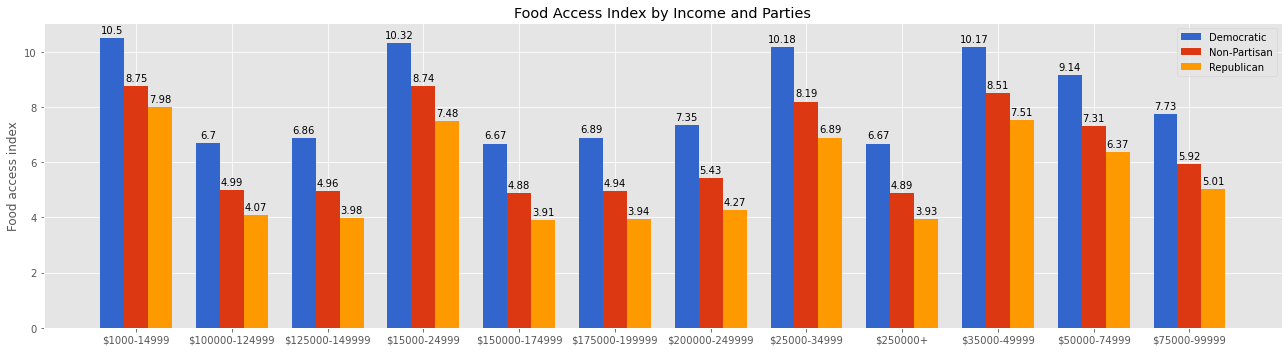

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = sorted(py_income_food_access_1mile['CommercialData_EstimatedHHIncome'].unique());
y_cols = list(py_income_food_access_1mile['Parties_Description'].unique());
y_vals = dict();
rects = dict();

for c in y_cols:
    cond = py_income_food_access_1mile['Parties_Description'] == c;
    y_vals[c] = list(np.array(py_income_food_access_1mile[cond]['Food_Access_Mean_1600']));

x = np.arange(len(labels));  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(18.0, 5.0));

color_idx = 0;
for c in y_cols:
    rects[c] = ax.bar(x + (width) * color_idx , y_vals[c], width, label='Food_Access_Mean_8000', color=colors[color_idx]);
    color_idx += 1;

ax.legend(rects); # add legend

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Food Access Index');
ax.set_title('Food Access Index by Income and Parties');
ax.set_xticks(x + width);
ax.set_xticklabels(labels);

# add lebeld
for c in y_cols:
    ax.bar_label(rects[c], padding=3);


plt.tight_layout();
plt.show();

## 12. Machine Learning

### 12A. Logistic Regression

#### Trying Logistic Regression with Food Index related columns as the only features to predict `General_2020`

In [ ]:
ML_sample = voter_data_MA.sample(fraction=0.05, seed=42)
ML_sample = ML_sample.select('Minimum_Index_Score_within_Block_Group','Maximum_Index_Score_within_Block_Group','Mean_Food_Access_Index_for_1600m','Mean_Food_Access_Index_for_8000m','General_2020')

In [ ]:
supervised = RFormula(formula="General_2020 ~ . ",handleInvalid='skip')
fittedRF = supervised.fit(ML_sample)
preparedDF = fittedRF.transform(ML_sample)
preparedDF.select('features', 'label').show(20, False)

+--------------------------+-----+
|features                  |label|
+--------------------------+-----+
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[10.0,10.0,10.0,15.0]     |0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
|[0.0,15.0,9.56790123,15.0]|0.0  |
|[0.0,15.0,9.56790123,15.0]|0.0  |
|[0.0,15.0,5.65354331,15.0]|0.0  |
+--------------------------+-----+
only showing top 20 rows



In [ ]:
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
train.show(1)

+--------------------------------------+--------------------------------------+--------------------------------+--------------------------------+------------+--------------------+-----+
|Minimum_Index_Score_within_Block_Group|Maximum_Index_Score_within_Block_Group|Mean_Food_Access_Index_for_1600m|Mean_Food_Access_Index_for_8000m|General_2020|            features|label|
+--------------------------------------+--------------------------------------+--------------------------------+--------------------------------+------------+--------------------+-----+
|                                     0|                                     0|                             0.0|                      4.78957529|           N|(4,[3],[4.78957529])|  1.0|
+--------------------------------------+--------------------------------------+--------------------------------+--------------------------------+------------+--------------------+-----+
only showing top 1 row



### 12B. Feature Importance with Logistic Regression

The purpose of this section is to figure what the most important features to figure out what voters are the most likely to vote. 

### Model on Training Set

In [ ]:
lr = LogisticRegression()
lrModel = lr.fit(train)

22/05/02 00:28:30 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/05/02 00:28:30 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [ ]:
summary = lrModel.summary
print("Train AUC:", summary.areaUnderROC)
roc = summary.roc.toPandas()
roc.head()

Train AUC: 0.5559693657091335


,FPR,TPR
0,0.000000,0.000000
1,0.000381,0.000655
2,0.000807,0.001260
3,0.001721,0.002091
4,0.001925,0.003578


Train AUC: 0.5559693657091335


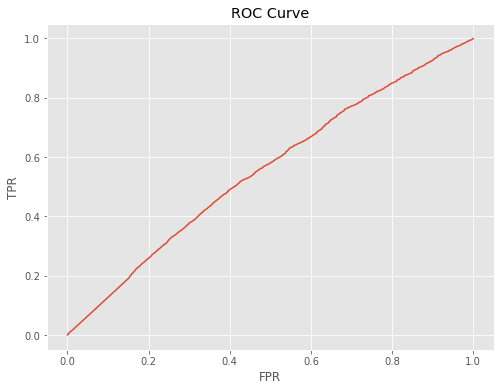

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

### Model on Test Set

In [ ]:
fittedTest = lrModel.transform(test)
fittedTest.select("label", "prediction", "rawPrediction").show(5, False)

+-----+----------+----------------------------------------+
|label|prediction|rawPrediction                           |
+-----+----------+----------------------------------------+
|1.0  |0.0       |[1.2362445809241995,-1.2362445809241995]|
|1.0  |0.0       |[1.2362445809241995,-1.2362445809241995]|
|0.0  |0.0       |[1.2362445809241995,-1.2362445809241995]|
|0.0  |0.0       |[1.2362445809241995,-1.2362445809241995]|
|0.0  |0.0       |[1.2362445809241995,-1.2362445809241995]|
+-----+----------+----------------------------------------+
only showing top 5 rows



In [ ]:
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))
print('Train AUC:', summary.areaUnderROC)

Test AUC: 0.5535580284237985
Train AUC: 0.5559693657091335


#### Food Access data alone does not very good model (AUC .55). Let's see how it looks with more features.

#### Trying to build a model to predict `General_2020` using more features. Opted to focus on key demographic variables as well as food access variables.

### Training

Train AUC: 0.7507809544093377


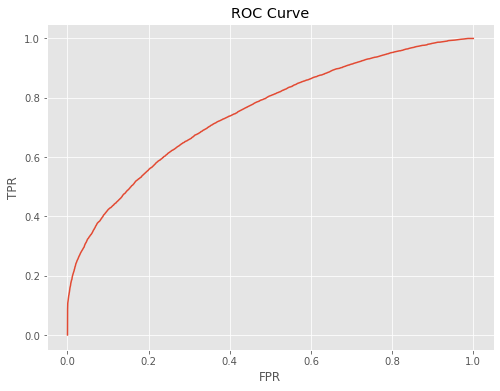

In [ ]:
ML_sample_all_features = voter_data_MA.sample(fraction=0.01, seed=42)
ML_sample_all_features = ML_sample_all_features.select(
'General_2020',
'COUNTY',
'Residence_Addresses_City',
'Residence_Addresses_Density',
'Parties_Description',
'CommercialData_EstHomeValue',
'CommercialData_EstimatedHHIncome',
'CommercialData_EstimatedHHIncomeAmount',
'CommercialData_ISPSA',
'CommercialData_LandValue',
'CommercialDataLL_Business_Owner',
'CommercialDataLL_Donates_to_International_Aid_Causes',
'CommercialDataLL_Gun_Owner',
'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household',
'CommercialDataLL_Veteran',
'Minimum_Index_Score_within_Block_Group',
'Maximum_Index_Score_within_Block_Group',
'Mean_Food_Access_Index_for_1600m',
'Mean_Food_Access_Index_for_8000m'
)

supervised = RFormula(formula="General_2020 ~ . ",handleInvalid='skip')
fittedRF = supervised.fit(ML_sample_all_features)
preparedDF = fittedRF.transform(ML_sample_all_features)

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 42)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression()
lrModel = lr.fit(train)

summary = lrModel.summary
roc = summary.roc.toPandas()
roc.head()

plt.rcParams["figure.figsize"] = (8,6)
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

### Test

In [ ]:
fittedTest = lrModel.transform(test)
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))

Test AUC: 0.7231179864479663


The following is a confusion matrix of the above to understand what the model was missing.

In [ ]:
y_true = fittedTest.select(['label']).collect()
y_pred = fittedTest.select(['prediction']).collect()

print(confusion_matrix(y_true, y_pred))

[[9362  305]
 [2476  851]]


#### Adding in more demographic factors made for a much better model compared to using food access alone (AUC .55 -> AUC .72)

#### Now the feature importance 

In [ ]:
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head(20)

,name
idx,
0,COUNTY_MIDDLESEX
1,COUNTY_WORCESTER
2,COUNTY_ESSEX
3,COUNTY_NORFOLK
4,COUNTY_SUFFOLK
5,COUNTY_BRISTOL
6,COUNTY_PLYMOUTH
7,COUNTY_HAMPDEN
8,COUNTY_BARNSTABLE


In [ ]:
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
#Feature Importance Code
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them

## Taking top 10 and bottom 10

coefsDF = pd.concat([coefsDF.head(10), coefsDF.tail(10)])

# coefsDF.head()

In [ ]:
len(coefsDF.name.unique())

20

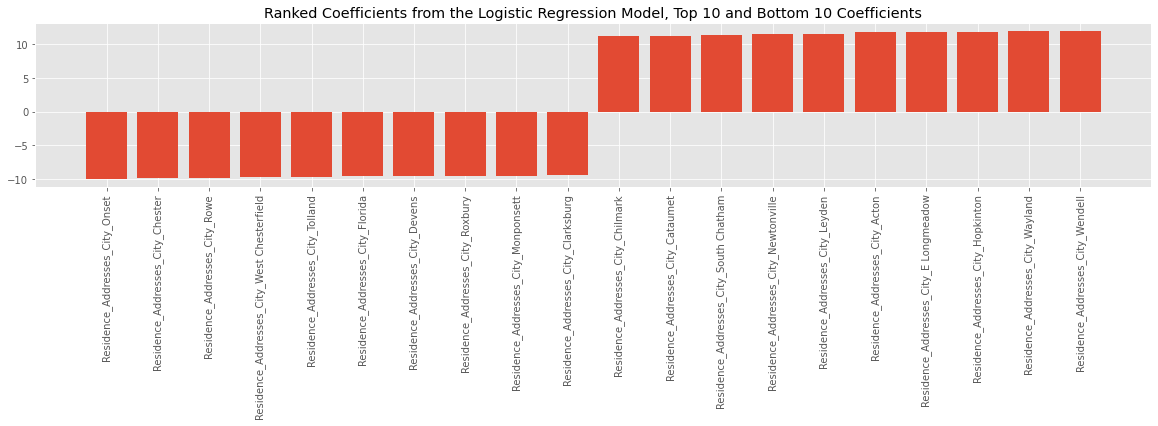

In [ ]:
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked Coefficients from the Logistic Regression Model, Top 10 and Bottom 10 Coefficients')
plt.show()

### 12C. Random Forest Classification Model 

In this section we will be performing a Random Forest classifier model. Random Forest work well with classifciation type models and will be put in direct competition with the logistic model we created above.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# train our model using training data
rf = RandomForestClassifier()
model = rf.fit(train)

# test our model and make predictions using testing data
predictions = model.transform(test)
#predictions.select("prediction", "labelIndex").show(5)

# evaluate the performance of the classifier
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g " % accuracy)

Test Error = 0.256041
Accuracy = 0.743959 


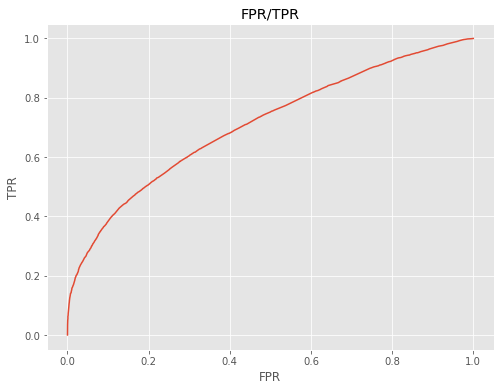

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.show()

In [ ]:
print('Test AUC:', model.summary.areaUnderROC)

Test AUC: 0.709812987943018


So we see a 0.69 AUC with the Random Forest Model 

In [ ]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      9667
         1.0       0.00      0.00      0.00      3327

    accuracy                           0.74     12994
   macro avg       0.37      0.50      0.43     12994
weighted avg       0.55      0.74      0.63     12994



/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(maxBins=20, subsamplingRate=0.7,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [10,20])\
  .addGrid(rf.numTrees, [50])\
  .build()

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=2)

In [ ]:
bestModel = cv.fit(train)

22/05/02 00:46:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1218.7 KiB
22/05/02 00:46:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1218.7 KiB
22/05/02 00:46:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1031.7 KiB
22/05/02 00:46:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1509.9 KiB
22/05/02 00:46:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1858.2 KiB
22/05/02 00:47:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/05/02 00:47:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/05/02 00:47:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/05/02 00:47:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting larg

In [ ]:
bestModel.avgMetrics

[0.6947704922235098, 0.719773510912556]

## 6. Conclusion

In conclusion, our initial analysis helped us understand basic key demographic features of the voters in our dataset. We learned that most voters are Christians, there seems to be a slightly greater number of Females compared to Males. We also learned that Boston has the greatest number of voters, Middlesex county has the greatest number of voters, and that the Household Income for most of the voters lies between the 50,000 and 150,000 range in US dollars. We also learend that the most common ethnicity is the European ethnicity, and that most voters carry a bachelors degree as their highest form of education. Suffolk seems to be the county with the greatest food access on average in both the 8000 and 1600m ranges, while Dukes has the lowest food access on average in both the 8000 and 1600m ranges. While Somerville is the city with the highest food access on average in the 8000 and 1600 meter ranges with Palmer City having the lowest food access on average.

When we went further and built machine learning models to predict whether or not a voter would turn out to vote, we learned that using the Food Index data alone was not enough to build a strong predictive model (we achieved an AUC of .55 with a logistic regression). However, once we added key demographic factors to the model such as the county/municipality or estimated household income we were able to create a model that was fairly well suited for predicting voter turnout with an AUC of .72.

## 7. Challenges
Our primary challenge was finding a quality field to use as a key to join our two primary datasets — the voter file and the Massachusetts Food Access Index database. The Food Access Index database had a geographic field, the Census Block Group ID, and after some initial research it was found that these IDs are constructed of codes corresponding to state, county, census tract, and census blocks which were all individual fields in the voter file. The task seemed straightforward enough: translate state and counties to their appropriate IDs and concatenate with the other values to arrive at a Census Block Group ID that could be used to join the two databases. However, we soon learned that some of the ID attributes were not in the correct format in the voter file data. For example, a proper Census Tract id, one piece of the Census Block Group ID that would be needed, is meant to be a six-digit number often including leading zeroes. In the voter file, however, the IDs were listed without leading zeroes. Additional work had to be done to make sure all elements of the ID were in the correct format before concatenating them to make a Census Block Group ID. 

This challenge highlighted two important realities when working with large datasets. The first is that the data is often not in the the most logical format. In the example above, even though a Census Tract is always 6 digits, at some point in the creation of the voter file an assumption was made that leading zeroes were unnecessary. Secondly, the importance of domain knowledge and research is important when working with vast datasets. Before our team researched how Census Block Group IDs are formed, it seemed that it would be impossible to create a value between the two datasets that would allow for a proper join. But after accumulating some domain knowledge — understanding that county IDs  or Census Tract IDs are always 3 digits, for example — were we able to see that the task was possible after further transformation. 


## Appendix 

### Exhibit A: Column Names and Data Types

**Census ID**
Census_2010_Block_Group_ID , StringType

**County Data** 
COUNTY , StringType
county_fips_id , StringType
SEQUENCE , IntegerType

**Voter Details**
LALVOTERID , StringType
Voters_Active , StringType
VoterTelephones_LandlineAreaCode , IntegerType
VoterTelephones_Landline7Digit , DoubleType
Voters_FirstName , StringType
Voters_LastName , StringType
Voters_Gender , StringType
Voters_BirthDate , StringType
Parties_Description , StringType
EthnicGroups_EthnicGroup1Desc , StringType
Religions_Description , StringType
Voters_OfficialRegDate , StringType
MaritalStatus_Description , StringType

**Residential Information**
Residence_Addresses_City , StringType
Residence_Addresses_Zip , IntegerType
Residence_Addresses_ZipPlus4 , IntegerType
Residence_Addresses_Density , IntegerType
Residence_HHGender_Description , StringType
Residence_HHParties_Description , StringType
City , StringType

**Commercial Data Information**
CommercialData_Education , StringType
CommercialData_EstHomeValue , DoubleType
CommercialData_EstimatedHHIncome , StringType
CommercialData_EstimatedHHIncomeAmount , DoubleType
CommercialData_HHComposition , StringType
CommercialData_ISPSA , IntegerType
CommercialData_LandValue , DoubleType
CommercialData_Occupation , StringType
CommercialData_PropertyType , StringType
CommercialDataLL_Business_Owner , StringType
CommercialDataLL_Donates_to_International_Aid_Causes , StringType
CommercialDataLL_Gun_Owner , StringType
CommercialDataLL_Home_Owner_Or_Renter , StringType
CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household , StringType
CommercialDataLL_HH_Net_Worth , StringType
CommercialDataLL_Veteran , StringType

**Election Returns**
ElectionReturns_G08CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_G10CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_G12CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_G14CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_G16CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_G18CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_P08CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_P10CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_P12CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_P14CountyTurnoutAllRegisteredVoters , StringType
ElectionReturns_P16CountyTurnoutAllRegisteredVoters , StringType

**Other Voting Information**
FECDonors_AvgDonation , DoubleType
Voters_VotingPerformanceEvenYearGeneral , StringType
Voters_VotingPerformanceEvenYearPrimary , StringType
Voters_VotingPerformanceEvenYearGeneralAndPrimary , StringType
Voters_VotingPerformanceMinorElection , StringType

**Election Data**
General_2022 , StringType
Primary_2022 , StringType
OtherElection_2022 , StringType
AnyElection_2021 , StringType
General_2020 , StringType
Primary_2020 , StringType
PresidentialPrimary_2020 , StringType
OtherElection_2020 , StringType
AnyElection_2019 , StringType
General_2018 , StringType
Primary_2018 , StringType
OtherElection_2018 , StringType
AnyElection_2017 , StringType
General_2016 , StringType
Primary_2016 , StringType
PresidentialPrimary_2016 , StringType
OtherElection_2016 , StringType
AnyElection_2015 , StringType
General_2014 , StringType
Primary_2014 , StringType
OtherElection_2014 , StringType
AnyElection_2013 , StringType
General_2012 , StringType
Primary_2012 , StringType
PresidentialPrimary_2012 , StringType
OtherElection_2012 , StringType
AnyElection_2011 , StringType
General_2010 , StringType
Primary_2010 , StringType
OtherElection_2010 , StringType
AnyElection_2009 , StringType
General_2008 , StringType
Primary_2008 , StringType
PresidentialPrimary_2008 , StringType
OtherElection_2008 , StringType
AnyElection_2007 , StringType
General_2006 , StringType
Primary_2006 , StringType
OtherElection_2006 , StringType
AnyElection_2005 , StringType
General_2004 , StringType
Primary_2004 , StringType
PresidentialPrimary_2004 , StringType
OtherElection_2004 , StringType
AnyElection_2003 , StringType
General_2002 , StringType
Primary_2002 , StringType
OtherElection_2002 , StringType
AnyElection_2001 , StringType
General_2000 , StringType
Primary_2000 , StringType
PresidentialPrimary_2000 , StringType
OtherElection_2000 , StringType
objectid , IntegerType

**Food Index Columns**
Minimum_Index_Score_within_Block_Group , IntegerType
Maximum_Index_Score_within_Block_Group , IntegerType
Mean_Food_Access_Index_for_1600m | **Definition: Mean Food Access Index for 1 mile (1600m) driveshed** | DoubleType
Mean_Food_Access_Index_for_8000m  | **Definition: Mean Food Access Index for 5 mile (8000m) driveshed** | DoubleType
